# Testing if Dan Foreman-Mackey's "money equation" works for my purposes.
Neglecting constant terms, his money equation is:

$$P(\{x_k\} | \gamma) = \prod_{k=1}^K \frac{1}{N_k} \sum_{n=1}^{N_k} \frac{Q_c(q_k^{(n)}) q_k^{-\gamma}}{P(obs|q_k)} $$

## Status as of end of day on Thursday, August 12
  - I can simulate the full sample parameters, and can grab random measurements of RV and imaging observables.
  - Next:
     - Add in observational uncertainties, and shift the measurements by appropriate amounts
     - Write code (subclass Fitters.Bayesian_LS) to fit the orbit to that information.
     - See what happens when I dial back the number of data points to a very small value.

## Status as of end of day on Sunday, August 23
  - I can simulate the full sample parameters, and can grab random measurements of RV and imaging observables.
  - Observables have gaussian uncertainties
  - Code exists to fit the orbit.
    - It works for fitting large numbers of observations
    - It is slow though. I think that is because of the astropy quantity stuff, so I will have to remove a lot of that and try again.
  - Next:
     - Speed up fitting code
     - See what happens when I dial back the number of data points to a very small value.
     - Calculate orbit fits for a bunch of things, and see how well the a,e,q distributions are reproduced.
     
## Status as of end of day on Monday, August 31
   - TODO: Figure out why the simulated $\omega_k$ parameters don't give the write distribution parameters ($\theta$) when I apply the money equation
   
## Status as of end of day on Wednesday, Sep 2
   - Money equation works for well-sampled orbits.
   - Played with fitting mostly un-constrained orbits. MultiNest works much better, so I am using that. Starting to push through the sample now to see what the Money Equation says.
   - We sometimes get the wrong answer for q. I suspect that is just something that happens when the orbits are so poorly sampled. What does the method that Trent uses give you.
     - TODO: Plot rv1 vs rv2, fit a straight line. The slope gives you q.
     
## Things to check before finalizing decision:

  1. How much does the prior on the orbit fit affect the final parameters? I am mostly concerned with the mass-ratio distribution
  2. How much do completeness effects impact things?
  3. How do things like malmquist bias affect things? Theoretically, that should go into the observed rate density as a kind of 'reverse completeness correction', I think...
  4. I am implicitly converting from semi-major axis to period by going through the q samples and the primary mass, which I assume is known and I am giving no uncertainty. How much does having the wrong mass mess with things?

In [2]:
# Import stuff
import numpy as np
import scipy
import Mamajek_Table
from scipy.stats import truncnorm, lognorm, powerlaw, norm
import matplotlib.pyplot as plt
import ForwardModeling
import Fitters
import Orbit
import pandas as pd
from astropy import units as u, constants
import IMF_utils
import pandas as pd
import h5py
import logging
import Distributions
import Simulation

from ForwardModeling import sample_orbit
from Distributions import teff2mass, mass2teff, OrbitPrior

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

%matplotlib inline

Module 'anfft' (FFTW Python bindings) could not be imported.
To install it, try running 'easy_install anfft' from the terminal.
Falling back on the slower 'fftpack' module for ND Fourier transforms.


:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [3]:
# True parameters
true_mrd_alpha = 0.4    # Mass-ratio distribution
true_error = 0.03
N_sample = 400     # Number of stars in sample
N_mcmc = 1e6
true_mult_rate = 0.5   # Multiplicity rate
true_sep_mu = np.log(200)   # Separation mean
true_sep_sigma = np.log(10)   # Separation spread
true_ecc_alpha = 0.7   # eccentricity distribution parameter
true_min_mass = 2.0    # Minimum primary mass
true_max_mass = 6.0    # maximum primary mass

In [3]:
np.random.seed(1)
sample_parameters =ForwardModeling.make_representative_sample(true_mrd_alpha, true_sep_mu, 
                                                              true_sep_sigma, true_ecc_alpha, 
                                                              size=N_sample, 
                                                              min_mass=true_min_mass, 
                                                              max_mass=true_max_mass)
sample_parameters.head()

M0    M_prim         Period            a   big_omega         e  \
0  192.113667  3.539377  328522.194060  8421.226711  264.011794  0.112358   
1  266.179603  3.188666     148.711637    48.896028   69.270441  0.002982   
2  185.541730  3.809597     204.281445    59.273182  173.320523  0.154194   
3  143.980533  3.006643      34.558613    16.906798  289.294066  0.989219   
4  355.048842  3.587567   29048.327655  1467.025372  142.915756  0.509465   

           i  little_omega         q  
0  33.624786    245.903057  0.563023  
1  58.427273     23.623920  0.657362  
2  52.652179     65.062517  0.309584  
3  43.216476    249.950498  0.345505  
4  25.601356    270.812378  0.042716

K1 = 17.4960919963
K2 = 50.6392037356


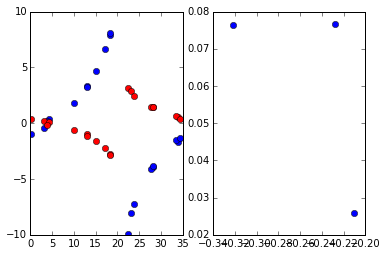

In [ ]:
reload(Orbit)
rv1_err = 0.1
rv2_err = 0.2
pos_err = 1e-2
t_rv, rv1, rv2, t_im, rho, theta, K1, K2 = sample_orbit(sample_parameters.ix[3], N_rv=20, N_imag=3,
                                                rv1_err=rv1_err, rv2_err=rv2_err, pos_err=pos_err)
fig, axes = plt.subplots(ncols=2, nrows=1)
axes[0].plot(t_rv, rv2, 'bo')
axes[0].plot(t_rv, rv1, 'ro')
x = rho * np.sin(theta)
y = rho * np.cos(theta)
axes[1].plot(x, y, 'bo')

# Orbit fitting
Now that I can generate random data, let's write some code to fit the orbits and make sure that I get the right answer for a wide range of guesses. The likelihood function is separable into velocity and imaging observables, and the primary and secondary velocity components are themselves separable:

$$\log{L_{rv}} \propto \frac{-0.5(v-m(t))^2}{ \sigma_v^2} $$
$$\log{L_{image}} \propto \frac{-0.5((x-m(t))^2 + (y-m(t))^2)}{ \sigma_{pos}^2}  $$

In [100]:
#reload(Orbit)
fitter = Orbit.FullOrbitFitter(rv_times=t_rv, imaging_times=t_im, 
                           rv1_measurements=rv1, rv1_err=rv1_err,
                           rv2_measurements=rv2, rv2_err=rv2_err, 
                           rho_measurements=rho, theta_measurements=theta, pos_err=pos_err)

In [105]:
#reload(Orbit)
#reload(Fitters)
#fitter.fit(backend='multinest', basename='fitting_test/single-', overwrite=True)
fitter.fit(backend='emcee', guess=False, initial_pars=true_pars, nwalkers=400, n_burn=400, n_prod=200)

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF

Running burn-in
Running production

INFO:root:Done with production iteration 1 / 200
INFO:root:Done with production iteration 11 / 200
INFO:root:Done with production iteration 21 / 200
INFO:root:Done with production iteration 31 / 200
INFO:root:Done with production iteration 41 / 200
INFO:root:Done with production iteration 51 / 200
INFO:root:Done with production iteration 61 / 200
INFO:root:Done with production iteration 71 / 200
INFO:root:Done with production iteration 81 / 200
INFO:root:Done with production iteration 91 / 200
INFO:root:Done with production iteration 101 / 200
INFO:root:Done with production iteration 111 / 200
INFO:root:Done with production iteration 121 / 200
INFO:root:Done with production iteration 131 / 200
INFO:root:Done with production iteration 141 / 200
INFO:root:Done with production iteration 151 / 200
INFO:root:Done with production iteration 161 / 200
INFO:root:Done with production iteration 171 / 200
INFO:root:Done with production iteration 181 / 200
INFO:root:Done with production iteration 1

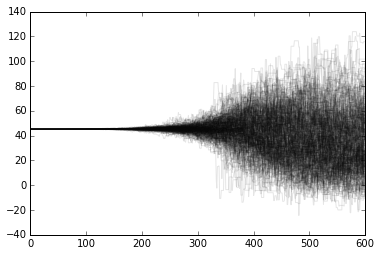

In [106]:
_ = plt.plot(fitter.sampler.chain[:, :, 1].T, 'k-', alpha=0.1)

In [22]:
n_burn = 400
fitter.make_emcee_samples(n_burn)

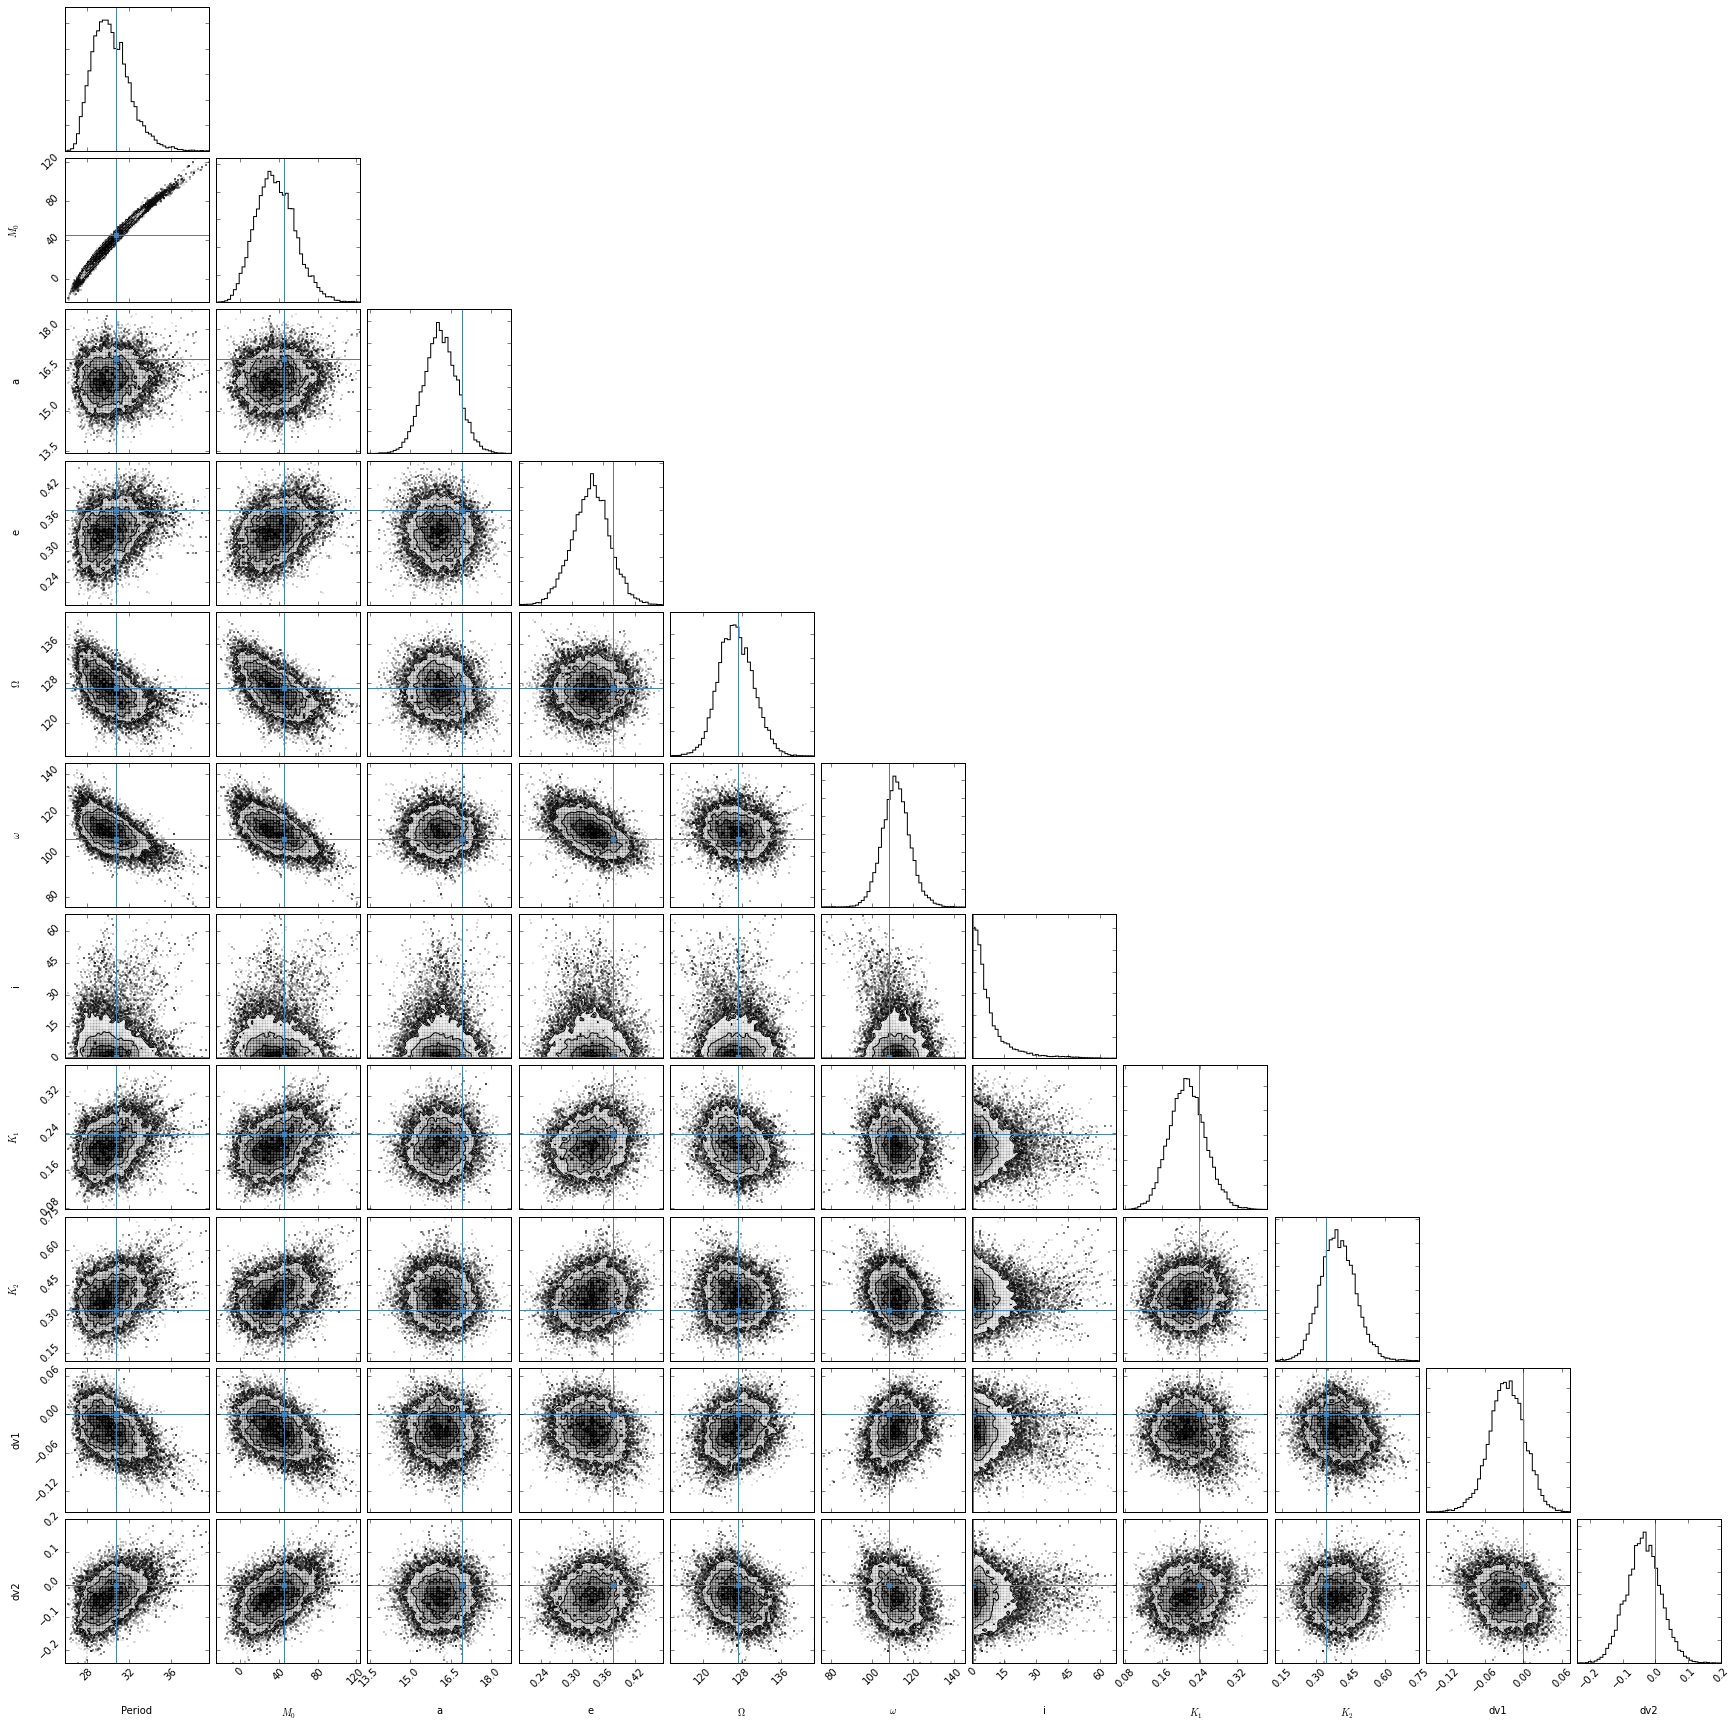

In [107]:
# Emcee results
fitter.triangle(truths=true_pars)

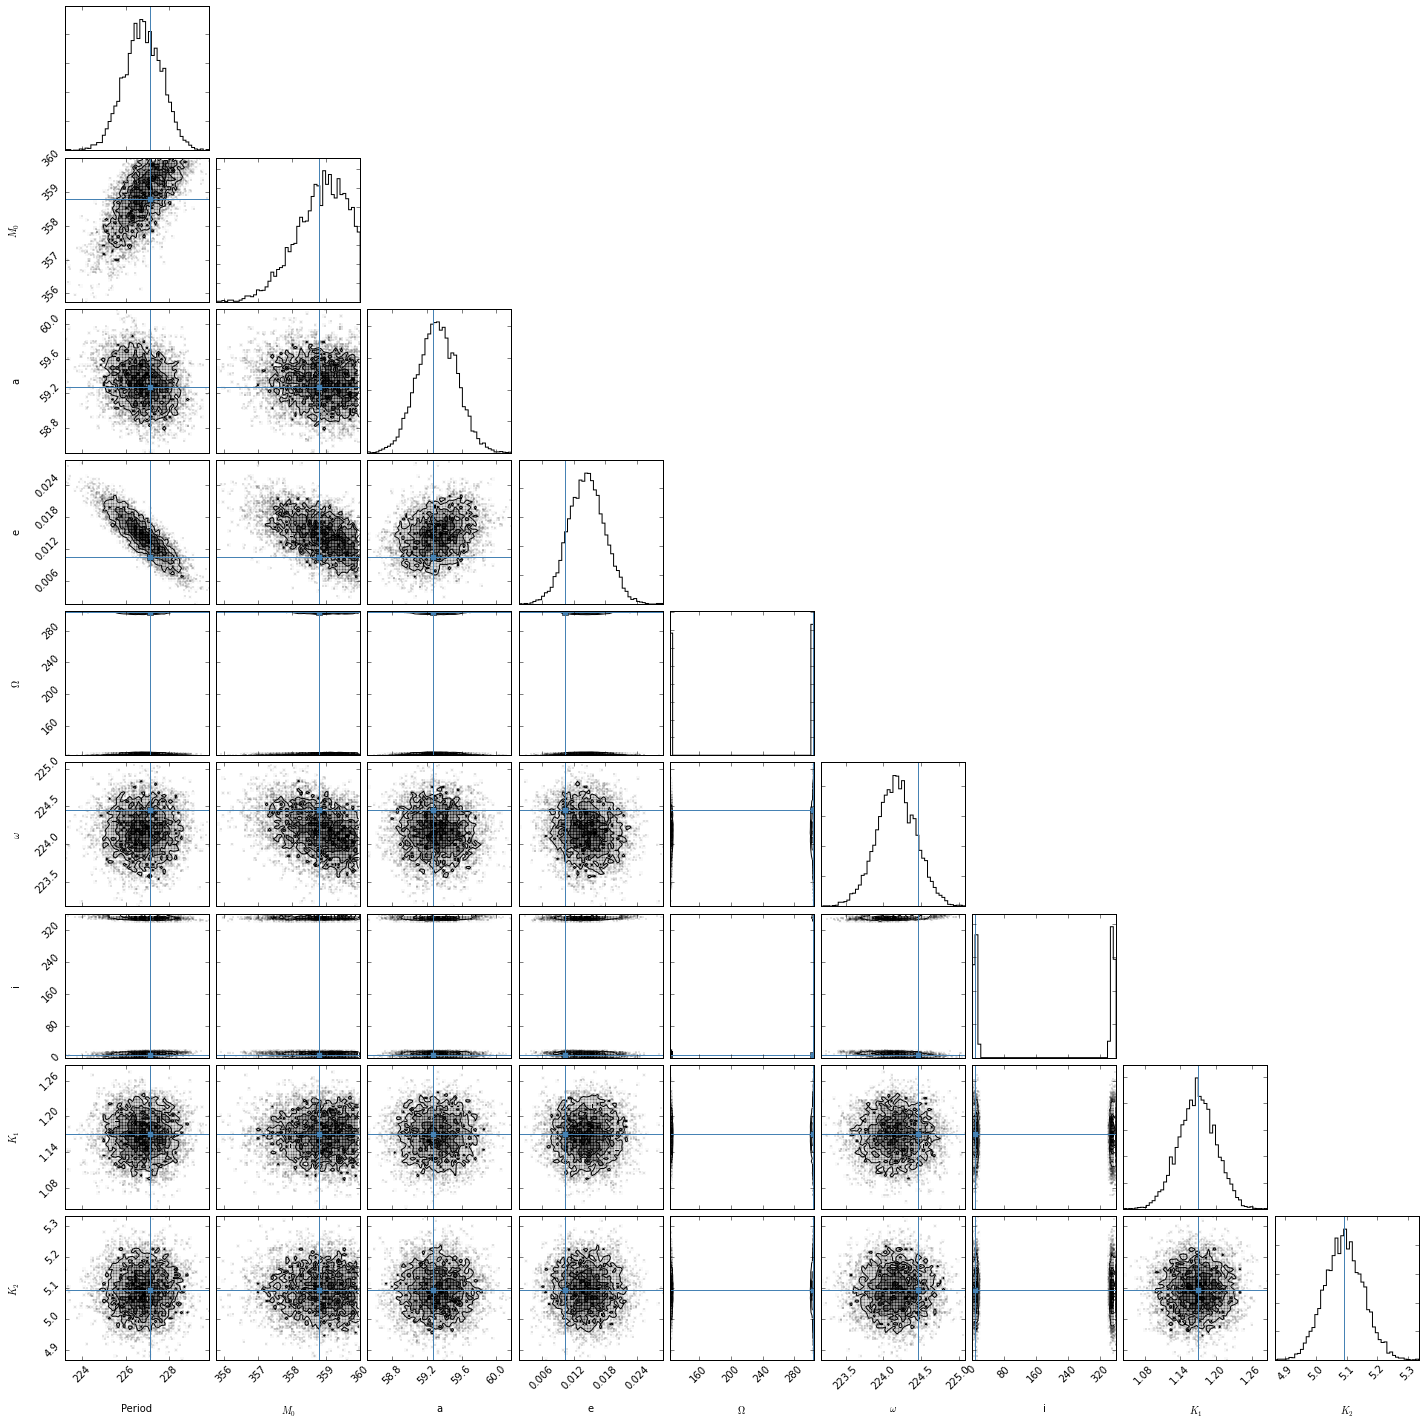

In [92]:
# multinest results
fitter.triangle(truths=true_pars)

# Fit several simulated stars
Save the MCMC samples in an HDF5 file to read in later and apply Dan's "Money Equation"

In [ ]:

#reload(Orbit)
outfile = pd.HDFStore('Simulation_Data.h5', 'a')
for i, row in sample_parameters.iterrows():
    # Make some observations of this binary system
    t_rv, rv1, rv2, t_im, rho, theta, K1, K2 = sample_orbit(row, N_rv=20, N_imag=3,
                                                    rv1_err=rv1_err, rv2_err=rv2_err, pos_err=pos_err)
        
    # Fit the orbit
    fitter = Orbit.FullOrbitFitter(rv_times=t_rv, imaging_times=t_im, 
                       rv1_measurements=rv1, rv1_err=rv1_err,
                       rv2_measurements=rv2, rv2_err=rv2_err, 
                       rho_measurements=rho, theta_measurements=theta, pos_err=pos_err)
    true_pars = [row['Period'], row['M0'], row['a'], row['e'], 
                 row['big_omega'], row['little_omega'], row['i'], 
                 K1, K2, 0.0, 0.0]
    print(i)
    fitter.fit(backend='emcee', guess=False, initial_pars=true_pars, nwalkers=400, n_burn=400, n_prod=300)
        
    # Save the MCMC samples
    outfile.put('production/ds{}'.format(i), fitter.samples, format='table', data_columns=True)
    outfile.flush()
    
outfile.close()

# Apply the Money Equation:
Here it is as written in the paper

$$P(\{x_k\} | \theta) = p(\{x_k\} | \alpha) \prod_{k=1}^K \frac{1}{N_k} \sum_{n=1}^{N_k} \frac{Q_c(\omega_k^{(n)}) \Gamma_{\theta}(\omega_k^{(n)})}{P(\omega_k^{(n)} | \alpha)} $$



The $x_k$ are the individual rv/imaging measurements, the $\omega_k^{(n)}$ are the orbital parameters for star k and MCMC chain n, and $\alpha$ encode the priors I used for finding the orbital parameters from the rv/imaging data. $Q_c$ is the completeness fraction for that set of parameters, and is unity in these simulations. I used uniform priors for all parameters, so $p(\{x_k\} | \alpha) = P(\omega_k^{(n)} | \alpha) = 1$

The $\theta$ I am trying to fit for is the set of parameters describing the semimajor axis, eccentricity, and mass-ratio distributions of the binary stars:

$$\Gamma(a, e, q | \gamma, \mu, \sigma, \eta) = \Gamma(q|\gamma) \Gamma(a|\mu, \sigma) \Gamma(e|\eta) $$

where

$$\Gamma(q|\gamma) = (1+\gamma)q^{\gamma} $$
$$\Gamma(a|\mu, \sigma) = \frac{1}{a\sigma\sqrt{2\pi}} e^{-0.5(\ln{a} - \mu)^2 / \sigma^2} $$
$$\Gamma(e|\eta) = (1+\eta)e^{\eta} $$

The full equation is then:

$$P(\{x_k\} | \gamma, \mu, \sigma, \eta) = \prod_{k=1}^K \frac{1}{N_k} \sum_{n=1}^{N_k} (1+\gamma)q_{k,n}^{\gamma} (1+\eta)e_{k,n}^{\eta} \frac{1}{a_{k,n}\sigma\sqrt{2\pi}} e^{-0.5(\ln{a_{k,n}} - \mu)^2 / \sigma^2} $$

That whole thing is just the likelihood function for the parameters we care about. We will have to find the maximum likelihood (another MCMC fit!) to get the best-fit parameters back. For that we need the log-likelihood:

$$ \ln{P(\{x_k\} | \gamma, \mu, \sigma, \eta)} = \sum_{k=1}^K \ln{ \sum_{n=1}^{N_k} \Gamma(q, a, e | \gamma, \mu, \sigma, \eta) } $$

Where I reverted back to using $\Gamma$ instead of the fully fleshed-out version as in the likelihood function.

In [3]:
infile = pd.HDFStore('Simulation_Data.h5', 'a')

In [4]:
# The production 'folder' in the hdf5 file has the full chains. We only want a few of the columns.
# Let's also thin the MCMC chains by a factor of 10 to speed things up
thin_factor = 10
for i in range(N_sample):
    if i % 25 == 0:
        logging.info(i)
    full_df = pd.read_hdf(infile, 'production/ds{}'.format(i))
    full_df['q'] = full_df['$K_1$'] / full_df['$K_2$']
    infile['thinned/ds{}'.format(i)] = full_df[['q', 'a', 'e']].sample(full_df.shape[0]/thin_factor)
    infile.flush()


INFO:root:0
INFO:root:25
INFO:root:50
INFO:root:75
INFO:root:100
INFO:root:125
INFO:root:150
INFO:root:175
INFO:root:200
INFO:root:225
INFO:root:250
INFO:root:275
INFO:root:300
INFO:root:325
INFO:root:350
INFO:root:375


In [18]:
# Additionally save the arrays as plain numpy arrays (even faster)
with h5py.File('Simulation_Data.h5', 'a') as f:
    for i in range(N_sample):
        df = infile['thinned/ds{}'.format(i)]
        f.create_dataset('plain/ds{}'.format(i), data=df.values)
        f.flush()
    

In [182]:
# Just make simulated datasets with the correct parameters
q_sigma = 0.01
e_sigma = 0.01
a_sigma = 1.0
with h5py.File('Simulation_Data.h5', 'a') as f:
    for i in range(N_sample):
        true_q, true_a, true_e = sample_parameters.ix[i][['q', 'a', 'e']]
        q = scipy.stats.truncnorm.rvs(a=-true_q/q_sigma, b=(1-true_q)/q_sigma, loc=true_q, scale=q_sigma, size=1000)
        a = scipy.stats.truncnorm.rvs(a=-true_a/a_sigma, b=np.inf, loc=true_a, scale=a_sigma, size=1000)
        e = scipy.stats.truncnorm.rvs(a=-true_e/e_sigma, b=(1-true_e)/e_sigma, loc=true_e, scale=e_sigma, size=1000)
        #print(true_q, true_a, true_e)
        data = np.array((q, a, e)).T
        #print(np.median(data, axis=0))
        f.create_dataset('simulated3/ds{}'.format(i), data=data)
        f.flush()

# Try out the fitter on the simulated data.



Measured value = 0.38


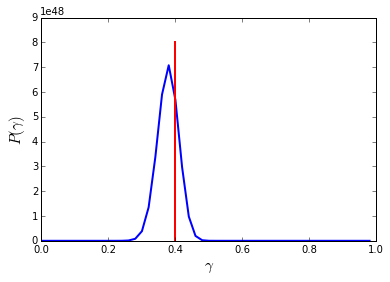

In [104]:
reload(Distributions)
with h5py.File('Simulation_Data_backup20150904.h5', 'r') as f:
    samples = np.array([f['plain/ds{}'.format(i)].value for i in range(N_sample)])
    
prior_fcn = lambda q, a, e: 1.0
completeness_fcn = lambda q, a, e: 1.0
integral_fcn = lambda gamma, mu, sigma, eta: 0.0
fitter = Distributions.DistributionFitter(samples, prior_fcn=prior_fcn, completeness_fcn=completeness_fcn,
                                          integral_fcn=integral_fcn)

gamma_vals = np.arange(0, 1, 0.02)
ll = np.zeros(gamma_vals.size)
for i, gamma in enumerate(gamma_vals):
    p = [gamma, 5.7, 2.3, 0.7]
    ll[i] = fitter._lnlike_stable(p)
    #print gamma, ll[i]

like = np.exp(ll - ll.mean())
centroid = np.sum(like * gamma_vals) / np.sum(like)
print ('Measured value = {:.2f}'.format(centroid))

%matplotlib inline
plt.plot(gamma_vals, like, lw=2)
plt.plot([0.4, 0.4], plt.ylim(), 'r-', lw=2)
plt.xlabel('$\gamma$', fontsize=15)
plt.ylabel('$P(\gamma)$', fontsize=15)

In [101]:
fitter.guess_fit_parameters()

INFO:root:[0.5, 5.0, 5.0, 0.5, 703.88310367223312]
INFO:root:[0.50000001000000005, 5.0, 5.0, 0.5, 703.88310517555101]
INFO:root:[0.5, 5.0000000099999999, 5.0, 0.5, 703.88310360693731]
INFO:root:[0.5, 5.0, 5.0000000099999999, 0.5, 703.88310430250681]
INFO:root:[0.5, 5.0, 5.0, 0.50000001000000005, 703.88309954824513]
Distributions.py:108: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(np.nansum(np.exp(ln_summand), axis=1)) - np.log(N_k)) - self.integral_fcn(gamma, mu, sigma, eta)
INFO:root:[0.0, 10.0, 0.001, 0.999, inf]
INFO:root:[1e-08, 10.0, 0.001, 0.999, inf]
INFO:root:[0.0, 10.000000010000001, 0.001, 0.999, inf]
INFO:root:[0.0, 10.0, 0.00100001, 0.999, inf]
INFO:root:[0.0, 10.0, 0.001, 0.99900001000000005, inf]
INFO:root:[0.49999999417893848, 5.000000058210615, 4.9999999418010272, 0.50000000580941939, 703.88309635312635]
INFO:root:[0.50000000417893853, 5.000000058210615, 4.9999999418010272, 0.50000000580941939, 703.88309785644401]
INFO:root:[0.49999999417893

array([ 0.37929035,  5.41539529,  2.24739706,  0.68831739])

## It works!
So this method shows promise if we have the full orbit fits. Unfortunately, we don't. What we have is 1-4 rv epochs, and 0-1 imaging epochs. In that case, the posterior samples for the orbit parameters ($\omega_k = q,a,e$) will be dominated by the priors of the fit. We can use priors from previous studies, but I want to check if the priors cause the distribution fitter to give the wrong answer. Thus, I will use the same functions for the priors with the following parameters (the true parameters I used in the simulation are shown in parentheses):

$$\gamma = 0.7 (0.4) \\
  \mu = 7.0 (5.3) \\
  \sigma = 3.0 (2.3) \\
  \eta = 0.3 (0.7) $$
  
So the first thing to test is how many MCMC samples it takes to converge to the posterior distribution when we only have a few measurements. I will try with 2 RV samples and no imaging (the most common case for my survey).

In [75]:
#reload(Orbit)
rv1_err = 0.1
rv2_err = 0.2
pos_err = 1e-2
idx = 9
print sample_parameters.ix[idx]
t_rv, rv1, rv2, t_im, _, _, K1, K2 = sample_orbit(sample_parameters.ix[idx], N_rv=2, N_imag=0,
                                                rv1_err=rv1_err, rv2_err=rv2_err, pos_err=pos_err)

M0               77.207354
M_prim            2.085752
Period          736.337991
a               112.631436
big_omega       162.490270
e                 0.000011
i                68.431719
little_omega    330.213657
q                 0.263157
Name: 9, dtype: float64
K1 = 0.882704256954
K2 = 3.35428533948


In [76]:
#reload(Orbit)
fitter = Orbit.SpectroscopicOrbitFitter(rv_times=t_rv, rv1_measurements=rv1, rv1_err=rv1_err, 
                                        rv2_measurements=rv2, rv2_err=rv2_err, primary_mass=sample_parameters.ix[idx, 'M_prim'])

In [ ]:
# Use emcee, starting with samples filling the entire possible parameter space
p = sample_parameters.ix[idx]
true_pars = [p['Period'], p['M0'], p['e'], p['little_omega'], K1, K1/K2, 0.0]
print(true_pars)
initial_pars = [[-3, 9], [0, 360], [-20, 0], [0, 360], [-3, 3], [0, 1], [-20, 20]]
fitter.fit(backend='emcee', nwalkers=300, n_prod=2500, guess=False, initial_pars=initial_pars)

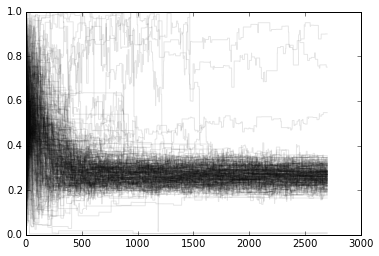

In [78]:
_ = plt.plot(fitter.sampler.chain[:, :, 5].T, 'k-', alpha=0.1)
fitter.make_emcee_samples(1000)

[  2.86707721e+00   7.72073536e+01  -4.96367422e+00   3.30213657e+02
  -5.41847790e-02   2.63157176e-01   0.00000000e+00]
[736.33799116039802, 77.207353607995117, 1.0872409082965053e-05, 330.2136572688031, 0.88270425695409271, 0.26315717585645493, 0.0]


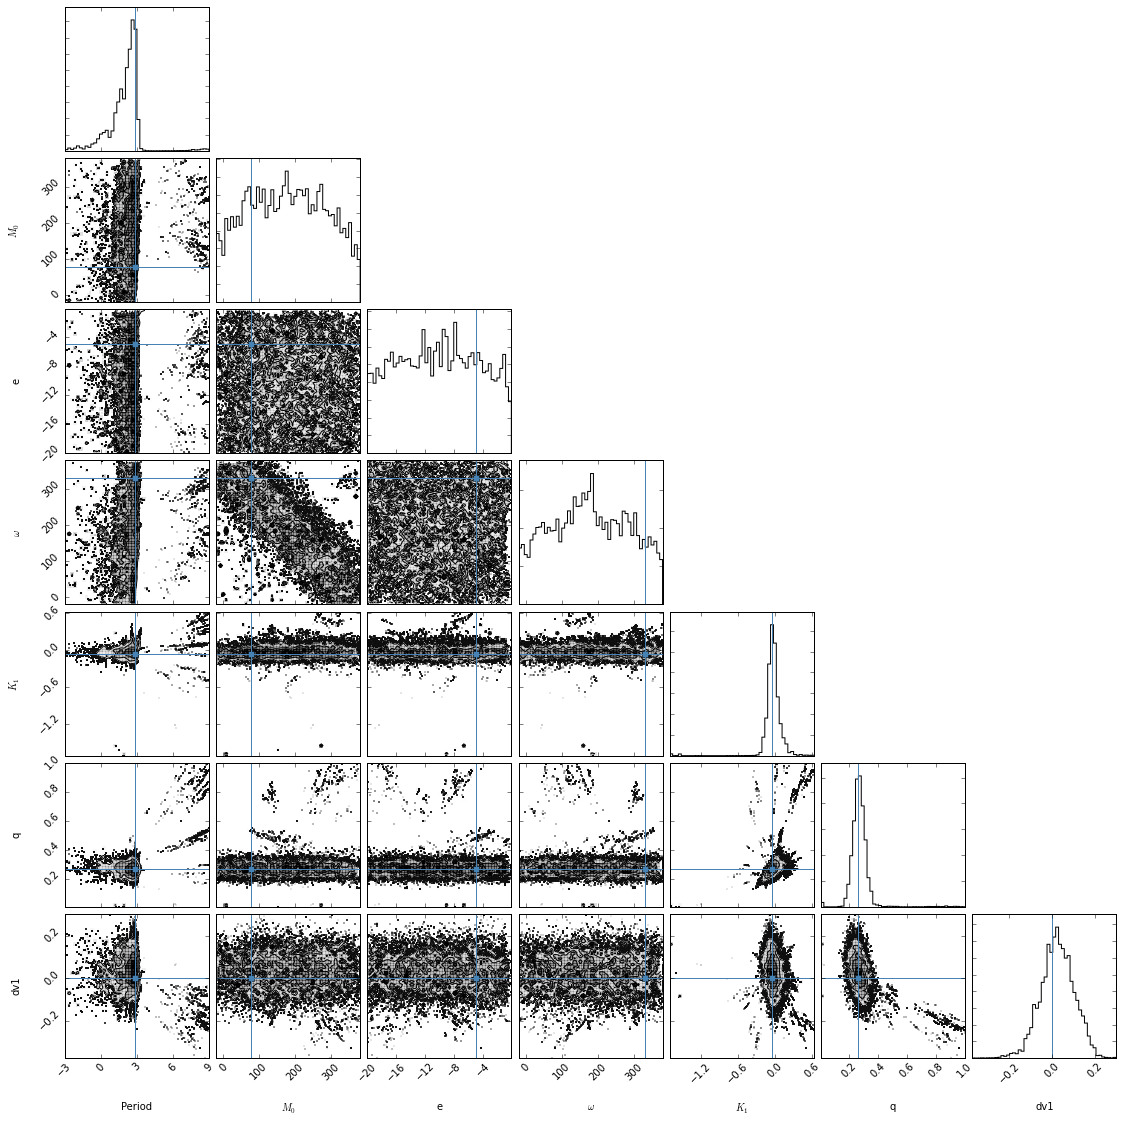

In [79]:
transformed_true_pars = np.array(true_pars).copy()
transformed_true_pars[0] = np.log10(transformed_true_pars[0])
transformed_true_pars[2] = np.log10(transformed_true_pars[2])
transformed_true_pars[4] = np.log10(transformed_true_pars[4])
fitter.triangle(truths=transformed_true_pars)
print(transformed_true_pars)
print(true_pars)

In [80]:
fitter.samples.describe()

$K_1$          $M_0$       $\omega$         Period  \
count  510000.000000  510000.000000  510000.000000  510000.000000   
mean       -0.034056     176.692581     178.621347       1.980103   
std         0.162887     105.386181     105.843704       1.308688   
min        -1.710109     -19.823140     -19.919141      -2.975112   
25%        -0.082409      89.017401      92.535295       1.472135   
50%        -0.034384     176.224432     177.258236       2.185748   
75%         0.019409     263.167648     266.451867       2.729491   
max         0.628213     379.838793     379.978473       8.999983   

                 dv1              e         lnprob              q  
count  510000.000000  510000.000000  510000.000000  510000.000000  
mean        0.025413     -10.147591      -0.993570       0.272090  
std         0.078078       5.469666      20.566431       0.070385  
min        -0.374743     -19.997590    -177.047867       0.005119  
25%        -0.023934     -14.774813       0.761489       0.242230  
50%         0.025391     -10.101074       2.064422       0.267849  
75%         0.077578      -5.620786       2.961570       0.294234  
max         0.300659      -0.129808       4.136897       0.999503

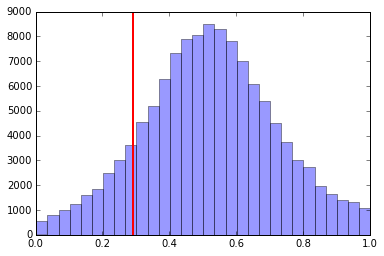

In [52]:
q = fitter.samples['q']
plt.hist(q, bins=30, alpha=0.4)
true_q = K1 / K2
plt.plot([true_q, true_q], plt.ylim(), 'r-', lw=2)

In [547]:
# Do we get the same thing with the multinest fitter?
fitter.fit(backend='multinest', basename='mn_unconstrained_test/idx{}-'.format(idx), overwrite=False)

[4863.763146094072, 140.7307361405249, 0.17777400094075141, 253.27718359251429, 0.45516469174785756, 0.29121719638431204, 0.0, 0.0]


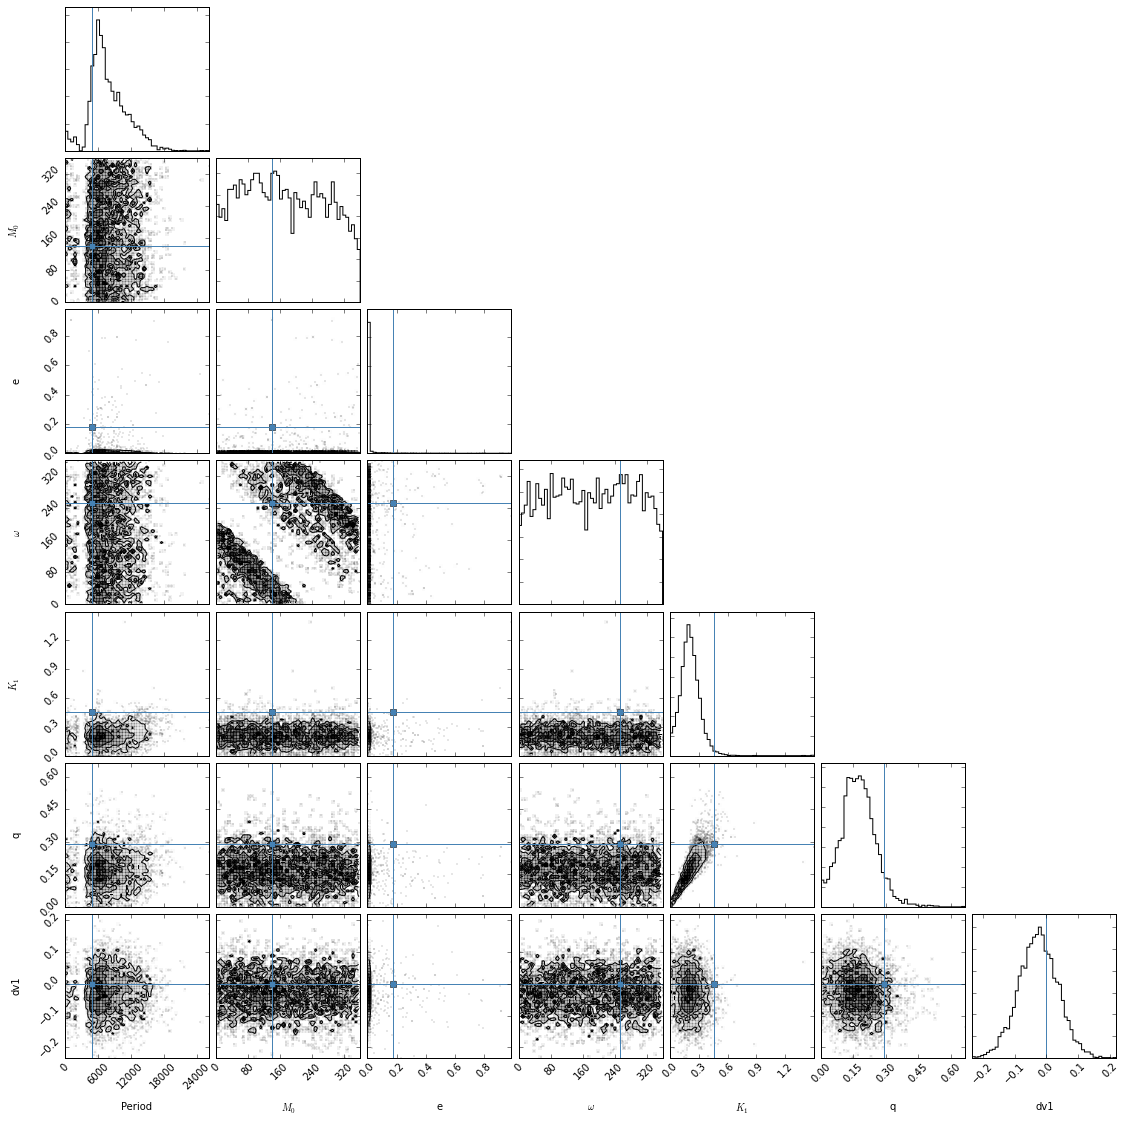

In [501]:
p = sample_parameters.ix[idx]
true_pars = [p['Period'], p['M0'], p['e'], p['little_omega'], K1, K1/K2, 0.0, 0.0]
print(true_pars)
fitter.triangle(truths=true_pars)

Percent of samples with q > true value = 6.292517%


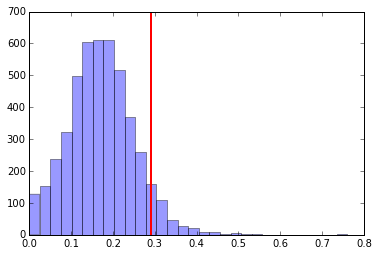

In [548]:
q = fitter.samples['q'] 
plt.hist(q, bins=30, alpha=0.4)
true_q = K1 / K2
plt.plot([true_q, true_q], plt.ylim(), 'r-', lw=2)
print 'Percent of samples with q > true value = {:%}'.format(sum(q>true_q)/float(len(q)))

## Lessons learned

We can usually do reasonably well with emcee if we start with the whole parameters space. Starting in a small ball near some "guess" solutions does very poorly for these unconstrained orbits. Even with the more robust starting conditions, emcee gives bad answers for very low mass-ratios. That doesn't really matter because I can't detect things that low, but still... 

MultiNest does a better job every time, so we will go ahead and use that for production. 

We need to use a prior on the mass-ratio distribution. In cases where the primary star does not change velocity, there is a degeneracy between mass-ratio and system velocity. Using a prior from the temperature data helps that, and doesn't play a huge role if the velocity information can constrain better.



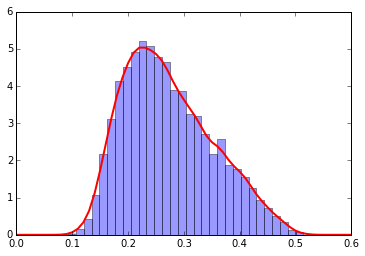

In [11]:
# Estimate P(q) from the information in sample_parameters
# First, sample values of q using the measured temperature and the primary star mass (+/- 1 Msun)
import Mamajek_Table
import scipy
MT = Mamajek_Table.MamajekTable()
teff2mass = MT.get_interpolator('Teff', 'Msun')
mass2teff = MT.get_interpolator('Msun', 'Teff')

M1_mean = sample_parameters.ix[idx, 'M_prim']
M1_std = 1.0
a, b = (1.5-M1_mean)/M1_std, np.inf
M1_vals = truncnorm.rvs(a=a, b=b, loc=M1_mean, scale=M1_std, size=10000)

T2_mean = mass2teff(sample_parameters.ix[idx, 'M_prim']*sample_parameters.ix[idx, 'q'])
T2_vals = np.random.normal(loc=T2_mean, scale=200, size=10000)
M2_vals = teff2mass(T2_vals)
q_vals = M2_vals/M1_vals

# Use kernel density estimation to get the PDF
kde = scipy.stats.gaussian_kde(q_vals)

_ = plt.hist(q_vals, bins=30, normed=True, alpha=0.4)
qplot = np.arange(*plt.xlim(), step=0.01)
_ = plt.plot(qplot, kde(qplot), 'r-', lw=2)

In [12]:
# Remake the fitter
#reload(Orbit)
fitter = Orbit.SpectroscopicOrbitFitter(rv_times=t_rv, rv1_measurements=rv1, rv1_err=rv1_err, 
                                        rv2_measurements=rv2, rv2_err=rv2_err, 
                                        primary_mass=sample_parameters.ix[idx, 'M_prim'], 
                                        q_prior=kde)


In [13]:
# Do we get the same thing with the multinest fitter?
fitter.fit(backend='multinest', basename='mn_unconstrained_qprior_test/idx{}-'.format(idx), overwrite=False)

[4863.763146094072, 140.7307361405249, 0.17777400094075141, 253.27718359251429, 0.45516469174785756, 0.29121719638431204, 0.0, 0.0]


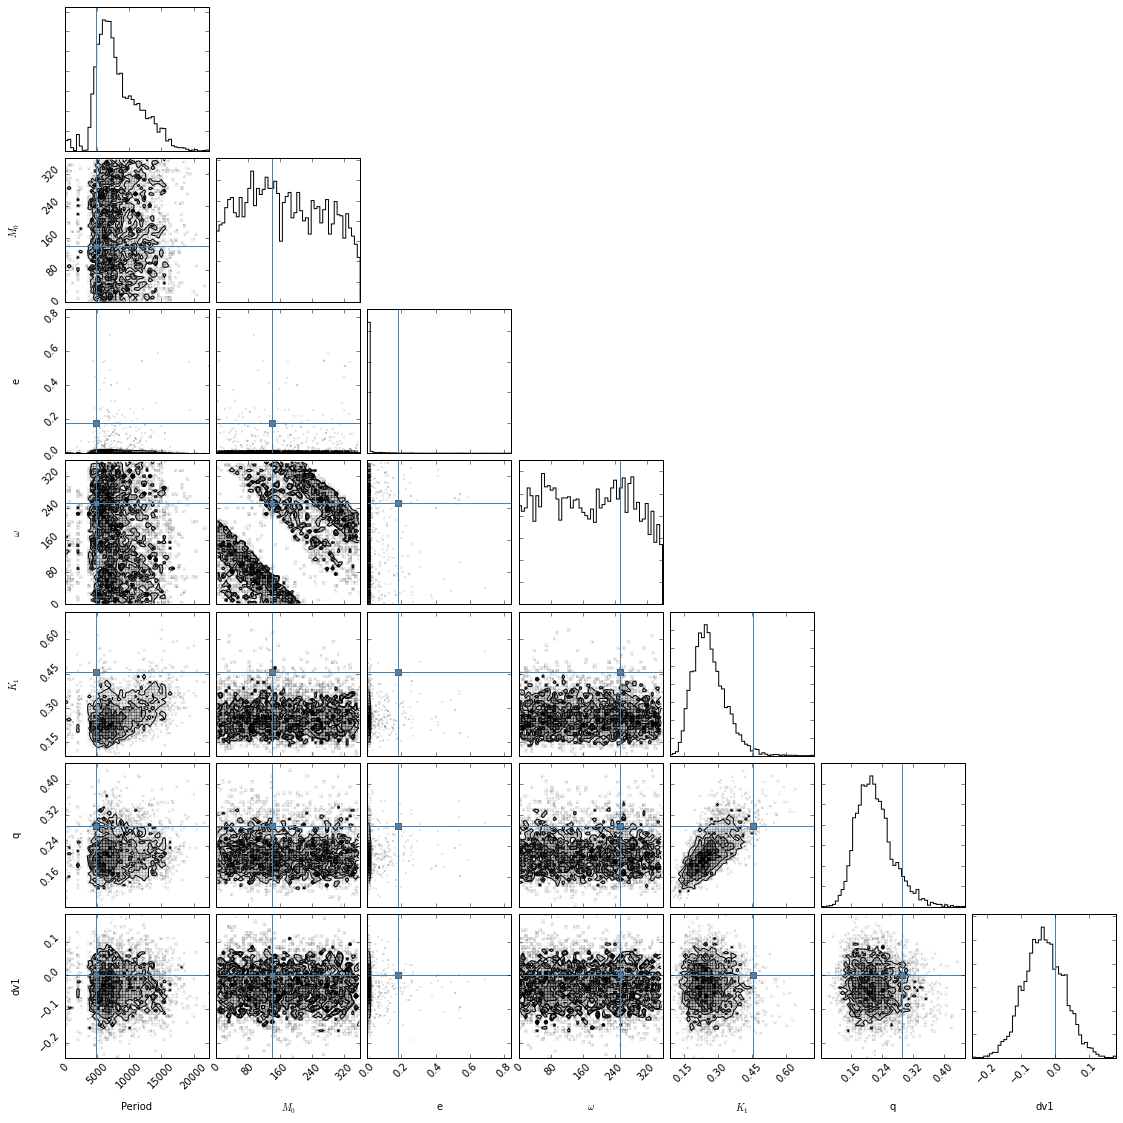

In [543]:
p = sample_parameters.ix[idx]
true_pars = [p['Period'], p['M0'], p['e'], p['little_omega'], K1, K1/K2, 0.0, 0.0]
print(true_pars)
fitter.triangle(truths=true_pars)

Percent of samples with q > true value = 8.604754%


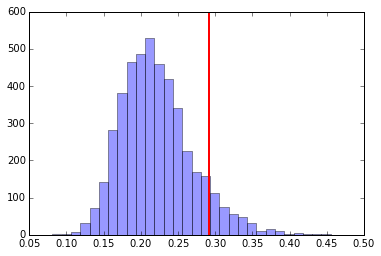

In [546]:
q = fitter.samples['q'] 
plt.hist(q, bins=30, alpha=0.4)
true_q = K1 / K2
plt.plot([true_q, true_q], plt.ylim(), 'r-', lw=2)
print 'Percent of samples with q > true value = {:%}'.format(sum(q>true_q)/float(len(q)))

## Well, that's a bit better...
It still really likes to have K1 and q off from their true values (they are correlated, obviously). Using the prior from the companion temperature measurement helps, but it just isn't strong enough to force the right answer. Let's take a look at some of the orbits.

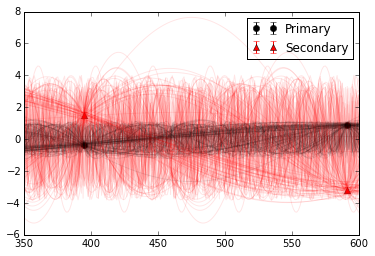

In [81]:
plt.errorbar(t_rv, rv1, yerr=rv1_err, fmt='ko', label='Primary')
plt.errorbar(t_rv, rv2, yerr=rv2_err, fmt='r^', label='Secondary')
xplot = {'t_rv': np.linspace(*plt.xlim(), num=200)}
rvs = fitter.predict(xplot, N=100)
for i in range(100):
    rv1_pred = rvs[i, 0, :]
    rv2_pred = rvs[i, 1, :]
    plt.plot(xplot['t_rv'], rv1_pred, 'k-', alpha=0.1)
    plt.plot(xplot['t_rv'], rv2_pred, 'r-', alpha=0.1)
leg = plt.legend(loc='best')
#plt.ylim((-2, 2))



That looks really reasonable, so there is probably nothing going wrong with the fit. It just likes the wrong values better because it is so unconstrained?

## Production
Alright, let's go ahead and do a bunch of really un-constrained fits to all 400 of my stars. I will save the results in the HDF5 file, along with the true parameters, so that I can compare later.

In [ ]:

rv1_err = 0.1
rv2_err = 0.2

output_base = 'unconstrained_mn_qprior2'
outfile = h5py.File('Simulation_Data.h5', 'a')
#reload(Orbit)
for i, row in sample_parameters.iterrows():
    print '\n\n{}'.format(i)
    # Make some observations of this binary system
    t_rv, rv1, rv2, t_im, rho, theta, K1, K2 = sample_orbit(row, N_rv=2, N_imag=0,
                                                    rv1_err=rv1_err, rv2_err=rv2_err)
        
    # Estimate the mass-ratio prior
    M1_mean = row['M_prim']
    T2_mean = mass2teff(row['M_prim']*row['q'])
    prior = OrbitPrior(M1_mean, T2_mean)
    q_prior = prior._evaluate_empirical_q_prior
    
    # Fit the orbit
    logging.debug('Creating Fitter...')
    fitter = Orbit.SpectroscopicOrbitFitter(rv_times=t_rv, rv1_measurements=rv1, rv1_err=rv1_err, 
                                        rv2_measurements=rv2, rv2_err=rv2_err, 
                                        primary_mass=M1_mean, 
                                        q_prior=q_prior)
    #true_pars = [row['Period'], row['M0'], row['e'], row['little_omega'], row['i'], K1, K1/K2, 0.0]
    logging.debug('Fitting...')
    fitter.fit(backend='multinest', basename='{}/idx{}-'.format(output_base, i), overwrite=False)
    #initial_pars = [[-3, 9], [0, 360], [-20, 0], [0, 360], [-3, 3], [0, 1], [-20, 20]]
    #fitter.fit(backend='emcee', nwalkers=300, n_burn=1000, n_prod=1500, guess=False, initial_pars=initial_pars) 
        
    # Save the MCMC samples and the true parameters
    logging.debug('Saving MCMC samples')
    try:
        ds = outfile.create_dataset('{}/ds{}'.format(output_base, i), data=fitter.samples, maxshape=(None, 8))
    except RuntimeError:
        ds = outfile['{}/ds{}'.format(output_base, i)]
        ds.resize(fitter.samples.shape)
        ds[:] = fitter.samples
    for par in row.keys():
        ds.attrs[par] = row[par]
    ds.attrs['K1'] = K1
    ds.attrs['K2'] = K2
    ds.attrs['df_columns'] = list(fitter.samples.columns)
    ds.attrs['t_rv'] = t_rv
    ds.attrs['rv1'] = rv1
    ds.attrs['rv2'] = rv2
    ds.attrs['rv1_err'] = rv1_err
    ds.attrs['rv2_err'] = rv2_err
    outfile.flush()
    
outfile.close()

In [274]:
import triangle
def triangle_plot(ds):
    """
    Make a triangle plot from a dataset created above
    """
    df = pd.DataFrame(data=ds.value, columns=ds.attrs['df_columns'])
    par_names = ['Period', '$M_0$', '$\\omega$', 'e', '$K_1$', 'q', 'dv1']
    samples = df[par_names].as_matrix()
    true_values = [np.log10(ds.attrs['Period']), ds.attrs['M0'], ds.attrs['little_omega'], 
                   np.log10(ds.attrs['e']), np.log10(ds.attrs['K1']), ds.attrs['q'], 0.0]
    print(true_values)
    triangle.corner(samples, labels=par_names, truths=true_values)

[u'unconstrained', u'unconstrained2', u'unconstrained_emcee_qrior', u'unconstrained_mn_malmquist', u'unconstrained_mn_noqprior', u'unconstrained_mn_qprior2', u'unconstrained_mn_qprior_fit_a']
[1.7579307996197229, 328.98379508877889, 109.10904333950383, -0.74644356919209276, 0.83250077442885306, 0.92092518272178481, 0.0]


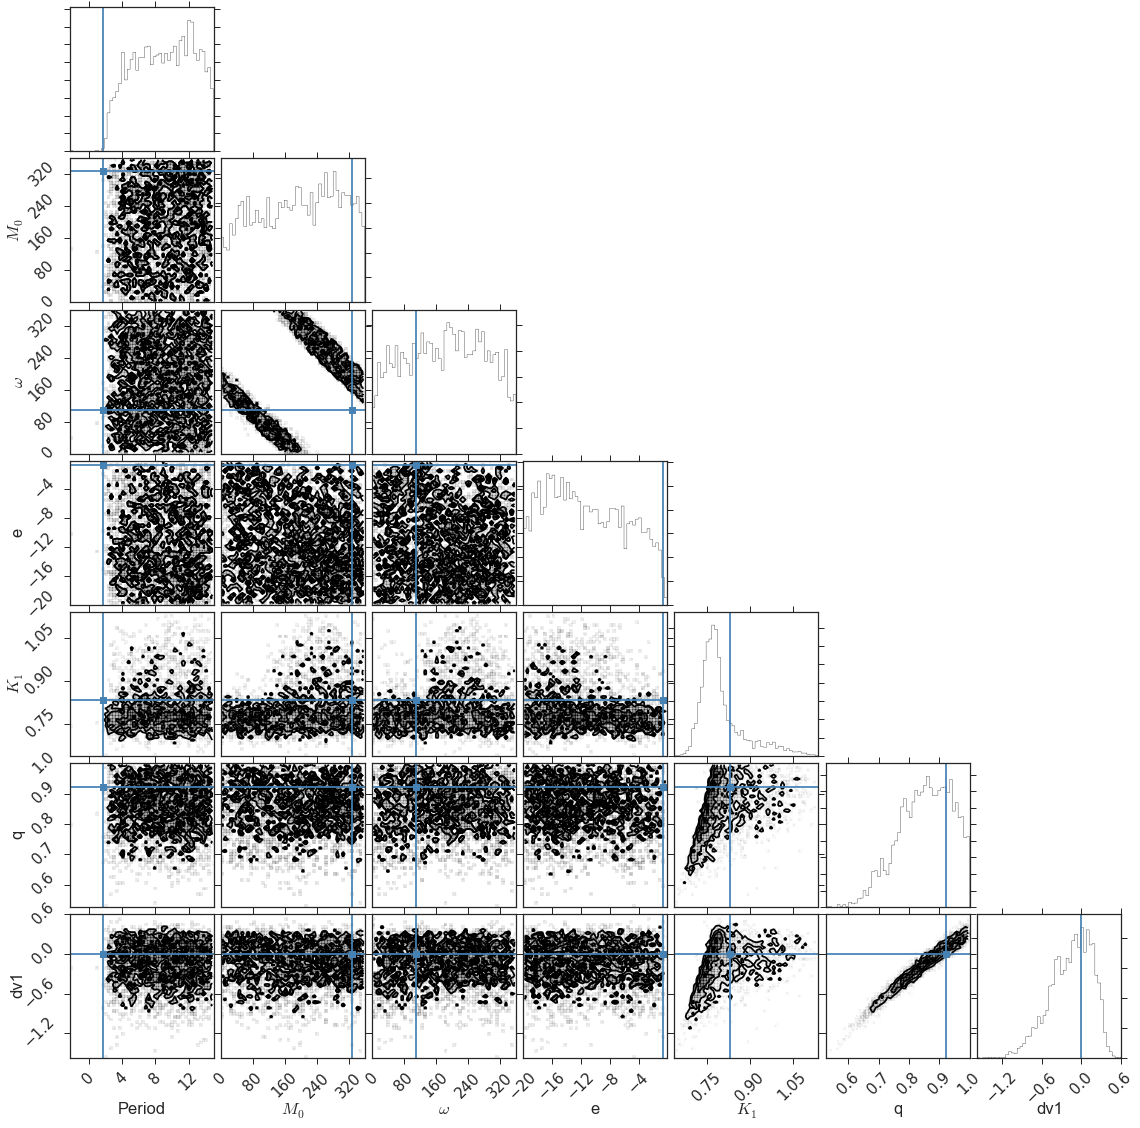

In [279]:
%matplotlib inline
with h5py.File('Simulation_Data.h5', 'r') as f:
    print(f.keys())
    #triangle_plot(f['unconstrained_mn_qprior_fit_a/ds399'])
    triangle_plot(f['unconstrained_mn_qprior2/ds113'])
    plt.savefig('Figures/with_qprior.png')
    """
    for ds_name, ds in f['unconstrained_mn_qprior'].iteritems():
        idx = np.where(ds.attrs['df_columns'] == 'Period')[0]
        #print ds.shape
        P = ds.value[:, idx]
        if np.log(ds.attrs['Period']) > 15 and np.nanmean(np.log(P)) < 10:
            print ds_name, np.log(ds.attrs['Period']), np.nanmean(np.log(P))
        #if np.log(ds.attrs['a']) > 14 and :
        #    print('{} q = {}'.format(ds_name, ds.attrs['q']))
    """

[1.7579307996197229, 328.98379508877889, 109.10904333950383, -0.74644356919209276, 0.83250077442885306, 0.92092518272178481, 0.0]


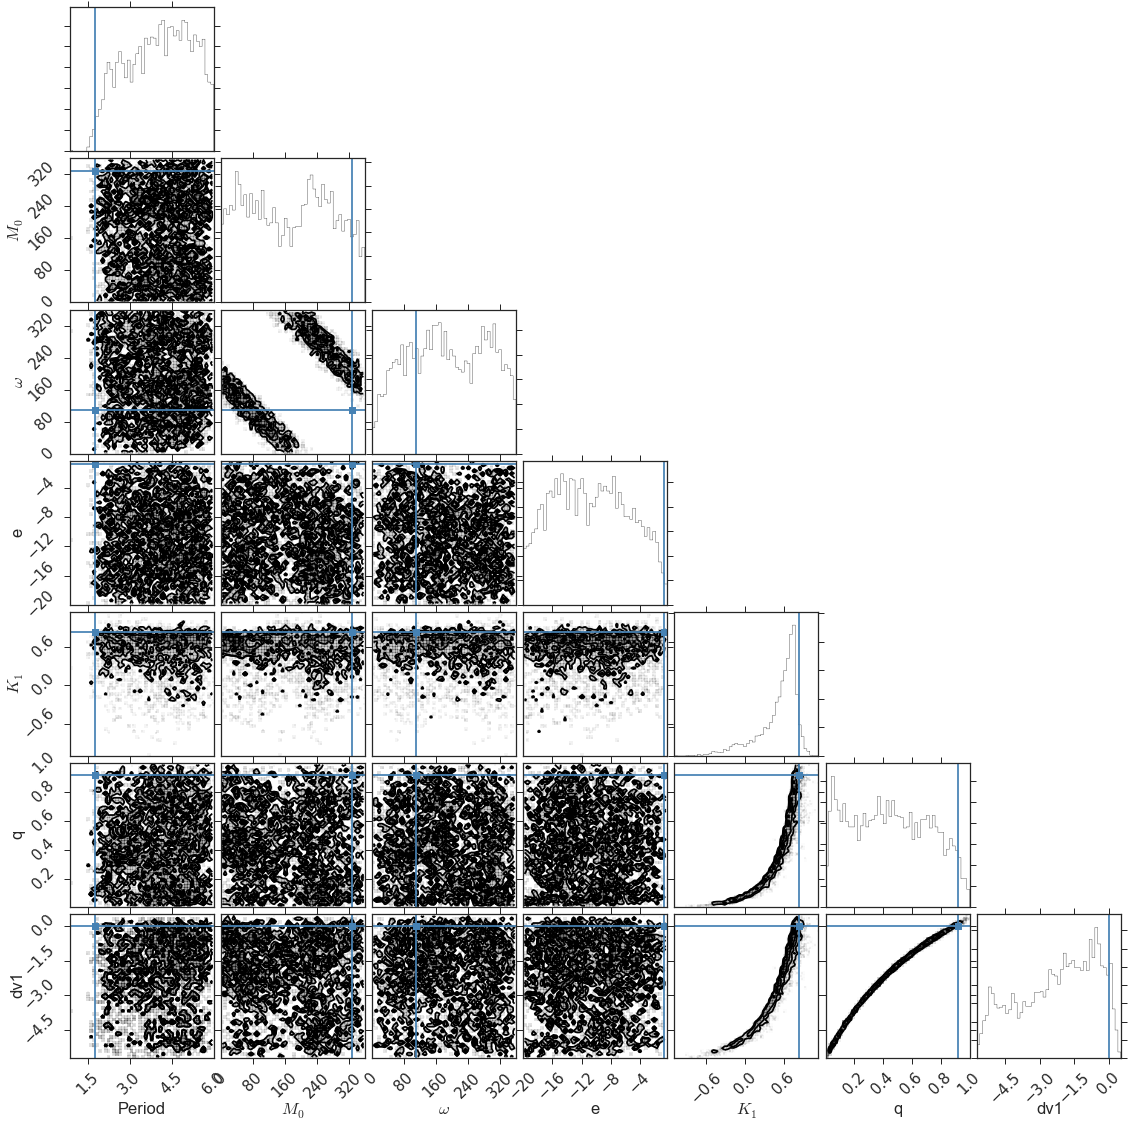

In [276]:
import seaborn as sns
sns.set_context('notebook', font_scale=1.5)
sns.set_style('white')
sns.set_style('ticks')
with h5py.File('Simulation_Data.h5', 'r') as f:
    triangle_plot(f['unconstrained_mn_noqprior/ds113'])
    plt.savefig('Figures/no_qprior.png')

# Distribution parameter estimation
Alright, the unconstrained orbit fits overall look alright (I just looked at a small sample of them, but $q$ is usually correct at least. The period is sometimes way off for some reason, but I wouldn't expect to be able to say much about the period from this data so I don't really care. The eccentricity is completely coming from the prior. Speaking of which...

I need to include the priors $p(\omega_k | \alpha)$ in the money equation now. The priors I used are:

  - mass-ratio (q): $P(q|\gamma, T_{\rm eff}, M_1) = (1-\gamma)q^{-\gamma} P(q|T_{\rm eff}, M_1) $
    - $P(q|T_{\rm eff}, M_1) $ comes from the simulated companion temperature measurement, and is different for each system! I estimate it by sampling from the companion temperature and primary mass distributions, and converting to mass-ratio through Eric Mamajek's spectral type conversion tables. It roughly constrains the mass-ratio to within $0.1-0.2$.
  - Eccentricity (e): $P(e) = \frac{1}{e\ln{10^{20}}}$
    - This is a log-uniform distribution for $10^{-20} < e < 1$. The lower limit should really be $-\infty$, but numerically this is the same and it lets the log function do the right thing.
  - Period (P): $P(P) = \frac{1}{P\ln{10^6}}$ (log-uniform from 1 day --> $10^6$ years)
  - I don't actually fit the semimajor axis, but can convert to it from the period prior using Kepler's law $P^2 = \frac{a^3}{M_1(1+q)}$
  - It works out to: $P(a|M_1, q) = \frac{1}{6a\ln{10}}$ if $10^{-2}[M_1(1+q)]^{(1/3)} < a < 10^{4}[M_1(1+q)]^{(1/3)}$ and 0 otherwise.
  
  
Coding up the prior is a bit difficult. I want a callable that takes the 2d numpy arrays a, e, and q and returns a single value. 

In [77]:
# Put all the relevant samples in a numpy array. 
with h5py.File('Simulation_Data.h5', 'r') as f:
    # First, get the maximum size
    maxlen = 0
    for _, dataset in f['unconstrained2'].iteritems():
        if dataset.shape[0] > maxlen:
            maxlen = dataset.shape[0]
    
    # Make a big numpy array filled with NaNs of max shape
    data = np.ones((len(f['unconstrained2']), maxlen, 3)) * np.nan
    M_prim = np.ones(len(f['unconstrained2'])) * np.nan
    M_sec = np.ones(len(f['unconstrained2'])) * np.nan
    
    # Fill the numpy array where possible
    for ds_name, dataset in f['unconstrained2'].iteritems():
        i = int(ds_name[2:])
        length = dataset.shape[0]
        df = pd.DataFrame(data=dataset.value, columns=dataset.attrs['df_columns'])
        M1 = dataset.attrs['M_prim']
        df['a'] = df['Period']**(2./3.) * (M1*(1+df['q']))**(1./3.)
        data[i, :length, :] = df[['q', 'a', 'e']]
        M_prim[i] = M1
        M_sec[i] = M1 * dataset.attrs['q']
        
        

In [78]:
import Mamajek_Table
MT = Mamajek_Table.MamajekTable()
teff2mass = MT.get_interpolator('Teff', 'Msun')
mass2teff = MT.get_interpolator('Msun', 'Teff')
T_sec = mass2teff(M_sec)

In [79]:
prior = OrbitPrior(M_prim, T_sec)

In [81]:
reload(Distributions)
dist_fitter = Distributions.DistributionFitter(data, prior)
#dist_fitter.guess_fit_parameters()

In [82]:
dist_fitter.guess_fit_parameters()

INFO:root:[0.5, 5.0, 5.0, 0.5, -1838.6720383684449]
INFO:root:[0.50000001000000005, 5.0, 5.0, 0.5, -1838.6720363712361]
INFO:root:[0.5, 5.0000000099999999, 5.0, 0.5, -1838.672038610478]
INFO:root:[0.5, 5.0, 5.0000000099999999, 0.5, -1838.6720378253649]
INFO:root:[0.5, 5.0, 5.0, 0.50000001000000005, -1838.6720450602811]
INFO:root:[0.0, 10.0, 0.001, 0.999, inf]
INFO:root:[1e-08, 10.0, 0.001, 0.999, inf]
INFO:root:[0.0, 10.000000010000001, 0.001, 0.999, inf]
INFO:root:[0.0, 10.0, 0.00100001, 0.999, inf]
INFO:root:[0.0, 10.0, 0.001, 0.99900001000000005, inf]
INFO:root:[0.49999999234921194, 5.0000000765078809, 4.9999999235074206, 0.50000000763548647, -1838.6720510119121]
INFO:root:[0.50000000234921194, 5.0000000765078809, 4.9999999235074206, 0.50000000763548647, -1838.6720490147036]
INFO:root:[0.49999999234921194, 5.0000000865078809, 4.9999999235074206, 0.50000000763548647, -1838.6720512539453]
INFO:root:[0.49999999234921194, 5.0000000765078809, 4.9999999335074206, 0.50000000763548647, -183

array([ 0.31220121,  6.48360038,  2.3320019 ,  0.93475777])

In [ ]:
dist_fitter.fit(backend='emcee', nwalkers=20, n_burn=1, n_prod=1000, guess=False, 
                initial_pars=[ 0.31220121,  6.48360038,  2.3320019 ,  0.93475777])

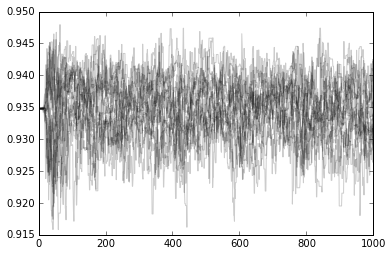

In [89]:
dist_fitter.n_params = 4
_ = plt.plot(dist_fitter.sampler.chain[:, :, 3].T, 'k-', alpha=0.2)
dist_fitter.make_emcee_samples(100)

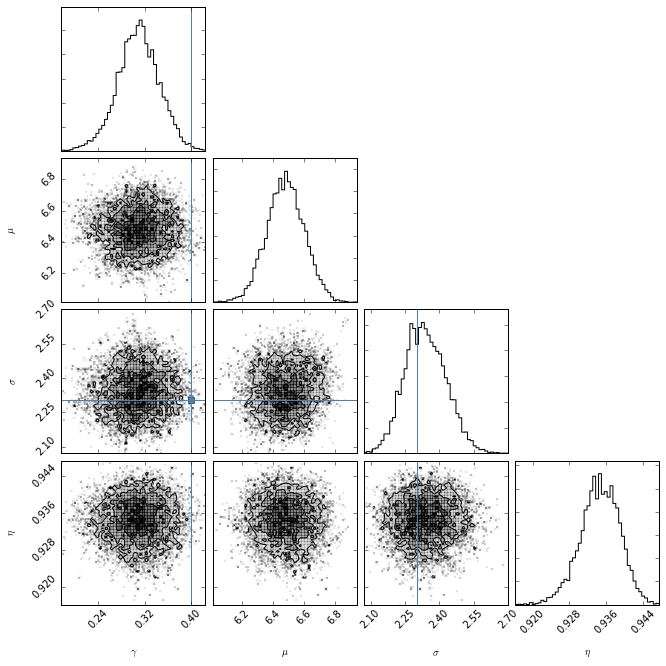

In [90]:
dist_fitter.triangle(truths=[0.4, np.log(200), np.log(10), 0.7])

# Wrong answer!
This gets the wrong answer for mass-ratio, and is much too precise for the period and eccentricity stuff. Oddly, it nails the separation distribution width. I think this may be related to the empirical mass-ratio prior for the really low-mass stuff. The spectral type relations only go down to M9 or so, and return nonsense after that. What if I limit my detections to q > 0.1 (just use a hard limit). I will need to use the Q variable now, which means the integral in Equation 11 matters. Hopefully this works better...

Based on playing around, I noticed that the very high mass-ratios tend to cause bad answers too. Basically, they have a (sometimes very long) tail that goes towards low q, but no tail to higher q because $ q < 1$. I will censor out the really high mass-ratios as well for now.

In [83]:
# Put all the relevant samples in a numpy array, censoring to "not detect" anything with q < 0.1. 
low = 0.05
high = 0.8
high = 1.0
#group_name = 'unconstrained_mn_qprior2'
group_name = 'unconstrained_mn_qprior_fit_a'
with h5py.File('Simulation_Data.h5', 'r') as f:
    print f.keys()
    
    # First, get the maximum size
    maxlen = 0
    n_datasets = 0
    for _, dataset in f[group_name].iteritems():
        if low <= dataset.attrs['q'] <= high:
            n_datasets += 1
            
            if dataset.shape[0] > maxlen:
                maxlen = dataset.shape[0]
    
    if 'emcee' in group_name.lower():
        maxlen = 2000 #Use ONLY for emcee fits!
    
    # Make a big numpy array filled with NaNs of max shape
    censored_data = np.ones((n_datasets, maxlen, 3)) * np.nan
    censored_M_prim = np.ones(n_datasets) * np.nan
    censored_M_sec = np.ones(n_datasets) * np.nan
    censored_Period = np.ones(n_datasets) * np.nan
    censored_a = np.ones(n_datasets) * np.nan
    censored_e = np.ones(n_datasets) * np.nan
    
    # Fill the numpy array where possible
    i = 0
    for ds_name, dataset in f[group_name].iteritems():
        if low <= dataset.attrs['q'] <= high:
            length = maxlen if 'emcee' in group_name.lower() else dataset.shape[0]
            #length = dataset.shape[0]
            df = pd.DataFrame(data=dataset.value, columns=dataset.attrs['df_columns'])
            M1 = dataset.attrs['M_prim']
            #df['a'] = 10**(df['Period']*(2./3.)) * (M1*(1+df['q']))**(1./3.)
            df['a'] = 10**df['Period']
            df['e'] = 10**(df['e'])
            values = df[['q', 'a', 'e']].sample(n=maxlen) if 'emcee' in group_name.lower() else df[['q', 'a', 'e']]
            #values = values.loc[(values['q'] >= low) & (values['q'] <= high)]
            #length = values.shape[0]
            censored_data[i, :length, :] = values
            censored_M_prim[i] = M1
            censored_M_sec[i] = M1 * dataset.attrs['q']
            censored_Period[i] = dataset.attrs['Period']
            censored_a[i] = dataset.attrs['a']
            censored_e[i] = dataset.attrs['e']
            i += 1

[u'unconstrained', u'unconstrained2', u'unconstrained_emcee_qrior', u'unconstrained_mn_noqprior', u'unconstrained_mn_qprior2', u'unconstrained_mn_qprior_fit_a']


In [84]:
censored_T_sec = mass2teff(censored_M_sec)
prior = OrbitPrior(censored_M_prim, censored_T_sec)
q = censored_data[:, :, 0]
a = censored_data[:, :, 1]
e = censored_data[:, :, 2]
#empirical_prior = prior._evaluate_empirical_q_prior(q)
#prior_val = empirical_prior * (1-0.4)*q**(-gamma)
#prior_val = prior(q, a, e)

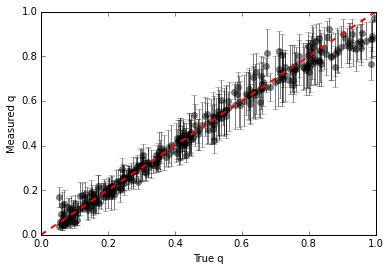

In [85]:
# Make a histogram of the median q values
q_median = np.nanmean(q, axis=1)
q_std = np.nanstd(q, axis=1)
fig = plt.figure()
_ = plt.errorbar(censored_M_sec/censored_M_prim, q_median, yerr=q_std, fmt='ko', alpha=0.5)
_ = plt.plot([0.0, 1], [0.0, 1], 'r--', lw=2)
plt.xlabel('True q')
plt.ylabel('Measured q')
#print np.mean(q, axis=1)

In [86]:
def simple_lnlike(gamma, q):
    #return -np.sum(-gamma*np.log(q) * np.greater_equal(q, 0.1).astype(np.int) )
    #print gamma, -gamma*np.sum(np.log(q)), np.log(1-gamma), np.log(1-0.1**(-gamma+1))
    #print q
    return -gamma*np.sum(np.log(q)) + q.size*np.log(1.0-gamma) - q.size*np.log(high**(1-gamma) - low**(1-gamma))# - q.size*np.log(1-0.1**(-gamma+1))

raw_q = q_median
#raw_q = censored_M_sec/censored_M_prim

simple_errfcn = lambda g, q: -simple_lnlike(g, q)

from scipy.optimize import minimize
out = minimize(simple_errfcn, 0.5, args=(np.array(raw_q),))#, bounds=[[-np.inf, 0.9999]])
print ('Fitting the mean mass-ratios gives gamma = {:.3f}'.format(out.x[0]))

Fitting the mean mass-ratios gives gamma = 0.434


KS-test p-value for different distributions = 0.707394467074


/home/kgullikson/anaconda3/envs/python2/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: RuntimeWarning: divide by zero encountered in power
/home/kgullikson/anaconda3/envs/python2/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: RuntimeWarning: divide by zero encountered in power


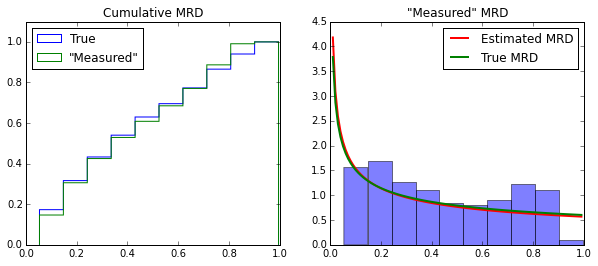

In [87]:
%matplotlib inline
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
_, bins, _ = axes[0].hist(censored_M_sec/censored_M_prim, bins=10, cumulative=True, histtype='step', label='True', normed=True)
axes[0].hist(q_median, bins=bins, cumulative=True, histtype='step', label='"Measured"', normed=True)
_ = axes[1].hist(raw_q, bins=bins, normed=True, alpha=0.5)
x = np.arange(0, 1, 0.01)
axes[1].plot(x, (1-out.x)*x**(-out.x), 'r-', lw=2, label='Estimated MRD')
axes[1].plot(x, (1-0.4)*x**(-0.4), 'g-', lw=2, label=('True MRD'))
axes[0].set_title('Cumulative MRD')
axes[1].set_title('"Measured" MRD')
axes[0].legend(loc=2)
axes[1].legend(loc=1)
axes[0].set_ylim((0, 1.1))

import scipy.stats
_, ks = scipy.stats.ks_2samp(censored_M_sec/censored_M_prim, q_median)
print ('KS-test p-value for different distributions = {}'.format(ks))

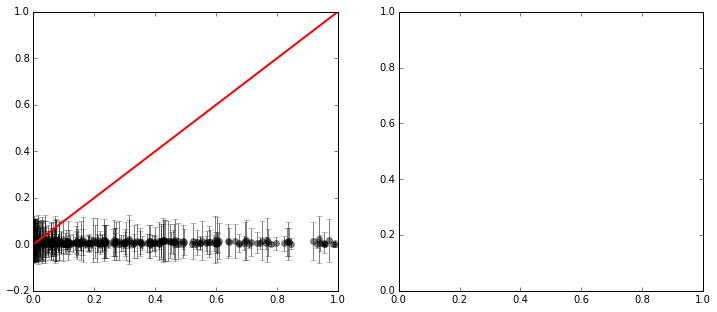

In [58]:
mean_e = np.nanmean(e, axis=1)
std_e = np.nanstd(e, axis=1)
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(12,5))
axes[0].errorbar(censored_e, mean_e, yerr=std_e, fmt='ko', alpha=0.5)
axes[0].plot([0, 1], [0, 1], 'r-', lw=2)


(335, 9425)


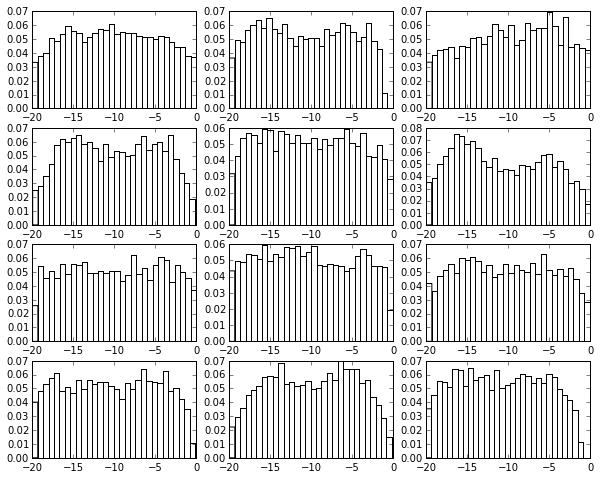

In [59]:
fig, axes = plt.subplots(4, 3, figsize=(10,8))
axes = axes.flatten()
print e.shape
for i in range(axes.size):
    ei = e[i, :]
    axes[i].hist(np.log10(ei[~np.isnan(ei)]), bins=30, color='white', normed=True)

(335, 8262)
(335,)
(335,)


(array([  4.,  10.,  27.,  54.,  84.,  72.,  54.,  17.,  11.,   2.]),
 array([ -1.13299852,   0.20801371,   1.54902594,   2.89003817,
          4.2310504 ,   5.57206263,   6.91307486,   8.25408709,
          9.59509931,  10.93611154,  12.27712377]),
 <a list of 10 Patch objects>)

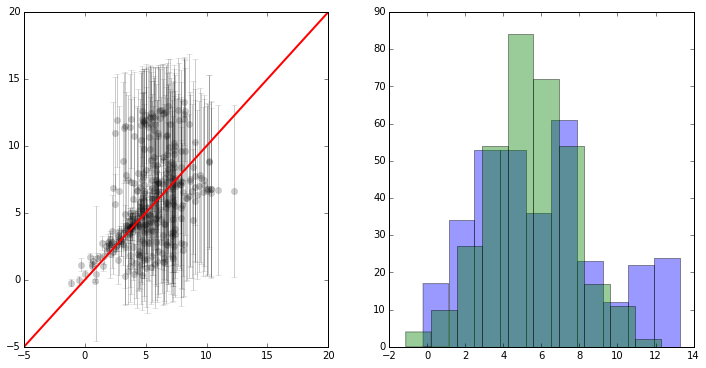

In [100]:
print a.shape
print censored_M_prim.shape
print censored_M_sec.shape
#P = np.sqrt((a**3).T / (censored_M_prim*(1+q.T)))
#mean_P = np.nanmean(np.log(P), axis=0)
#std_P = np.nanstd(np.log(P), axis=0)
mean_a = np.nanmean(np.log(a), axis=1)
std_a = np.nanstd(np.log(a), axis=1)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
axes[0].errorbar(np.log(censored_a), mean_a, yerr=std_a, fmt='ko', alpha=0.2)
axes[0].plot([-5, 20], [-5, 20], 'r-', lw=2)
#axes[1].hist(np.log(censored_Period))
#axes[1].hist(mean_P)
axes[1].hist(mean_a, alpha=0.4)
axes[1].hist(np.log(censored_a), alpha=0.4)

In [93]:
# Make the completeness function. The simple thing I have is analytical.
completeness = lambda q, a, e: np.greater_equal(q, low).astype(np.int) * np.less_equal(q, high).astype(np.int) * q.shape[0]
integral = lambda gamma, mu, sigma, eta: high**(1-gamma) - low**(1-gamma) * N_sample
def prior_fcn_simple(q, a, e):
    a_prior = 1.0 / (10*a*np.log(10))
    e_prior = 1.0 / (20*e*np.log(10))
    #q_prior = (1 - 0.4)*q**(-0.4)
    q_prior = 1.0
    return a_prior * e_prior * q_prior
    #return q_prior

prior_fcn = OrbitPrior(censored_M_prim, censored_T_sec)
empirical_prior = prior_fcn._evaluate_empirical_q_prior(q)


In [94]:
reload(Distributions)
censored_dist_fitter = Distributions.DistributionFitter(censored_data, 
                                                        prior_fcn=prior_fcn_simple, 
                                                        completeness_fcn=completeness,
                                                        integral_fcn=integral,
                                                        #q_limits=(low, high))
                                                        q_limits=(0, 1.0))
censored_dist_fitter.prior = empirical_prior
censored_dist_fitter.lnp = np.log(censored_dist_fitter.prior)
#censored_dist_fitter.lnp = 0.0
#censored_dist_fitter.completeness = 1.0
#censored_dist_fitter.ln_completeness = 0.0

Measured value = 0.348


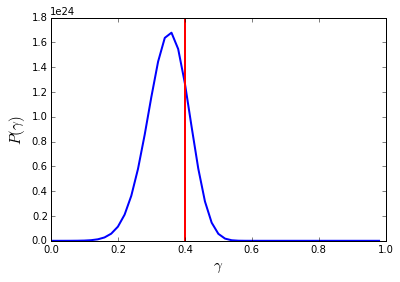

In [95]:
gamma_vals = np.arange(0, 1, 0.02)
ll = np.zeros(gamma_vals.size)
for i, gamma in enumerate(gamma_vals):
    p = [gamma, 5.7, 2.3, 0.7]
    ll[i] = censored_dist_fitter._lnlike_stable(p)

like = np.exp(ll - ll.mean())
centroid = np.sum(like * gamma_vals) / np.sum(like)
print ('Measured value = {:.3f}'.format(centroid))

%matplotlib inline
plt.plot(gamma_vals, like, lw=2)
plt.plot([0.4, 0.4], plt.ylim(), 'r-', lw=2)
plt.xlabel('$\gamma$', fontsize=15)
plt.ylabel('$P(\gamma)$', fontsize=15)

In [96]:
# Estimate the best parameters using normal optimization
guess_pars = censored_dist_fitter.guess_fit_parameters()
print guess_pars

INFO:root:[0.5, 5.0, 5.0, 0.5, -7433.0019020975806]
INFO:root:[0.50000001000000005, 5.0, 5.0, 0.5, -7433.0019015721282]
INFO:root:[0.5, 5.0000000099999999, 5.0, 0.5, -7433.0019021323105]
INFO:root:[0.5, 5.0, 5.0000000099999999, 0.5, -7433.0019018303001]
INFO:root:[0.5, 5.0, 5.0, 0.50000001000000005, -7433.0020408644659]
INFO:root:[0.0, 8.4729964697309956, 0.001, 0.999, inf]
INFO:root:[1e-08, 8.4729964697309956, 0.001, 0.999, inf]
INFO:root:[0.0, 8.4729964797309965, 0.001, 0.999, inf]
INFO:root:[0.0, 8.4729964697309956, 0.00100001, 0.999, inf]
INFO:root:[0.0, 8.4729964697309956, 0.001, 0.99900001000000005, inf]
INFO:root:[0.49999993429253003, 5.0000004564036225, 4.9999993430567153, 0.50000006557605503, -7433.0028346725276]
INFO:root:[0.49999994429253003, 5.0000004564036225, 4.9999993430567153, 0.50000006557605503, -7433.0028341470743]
INFO:root:[0.49999993429253003, 5.0000004664036224, 4.9999993430567153, 0.50000006557605503, -7433.0028347072584]
INFO:root:[0.49999993429253003, 5.000000

[ 0.3608768   5.02839555  2.63143722  0.999     ]


In [101]:
par_ranges = [[0, 0.999], [1e-3, 10], [1e-3, 10], [0, 0.999] ]
censored_dist_fitter.fit(backend='emcee', nwalkers=100, n_burn=1, n_prod=400, guess=False, 
                         initial_pars=par_ranges)

INFO:root:Done with burn-in iteration 1 / 1


Running burn-in
Running production

INFO:root:Done with production iteration 1 / 400
INFO:root:Done with production iteration 11 / 400
INFO:root:Done with production iteration 21 / 400
INFO:root:Done with production iteration 31 / 400
INFO:root:Done with production iteration 41 / 400
INFO:root:Done with production iteration 51 / 400
INFO:root:Done with production iteration 61 / 400
INFO:root:Done with production iteration 71 / 400
INFO:root:Done with production iteration 81 / 400
INFO:root:Done with production iteration 91 / 400
INFO:root:Done with production iteration 101 / 400
INFO:root:Done with production iteration 111 / 400
INFO:root:Done with production iteration 121 / 400
INFO:root:Done with production iteration 131 / 400
INFO:root:Done with production iteration 141 / 400
INFO:root:Done with production iteration 151 / 400
INFO:root:Done with production iteration 161 / 400
INFO:root:Done with production iteration 171 / 400
INFO:root:Done with production iteration 181 / 400
INFO:root:Done with production iteration 1

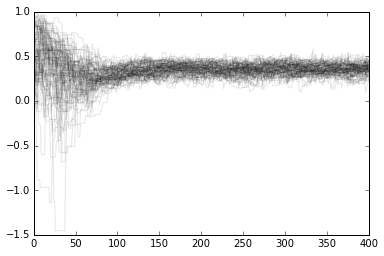

In [103]:
_ = plt.plot(censored_dist_fitter.sampler.chain[:, :, 0].T, 'k-', alpha=0.1)
censored_dist_fitter.make_emcee_samples(200)

In [280]:
censored_dist_fitter.triangle(truths=[0.4, 5.3, 2.3, 0.7])

NameError: name 'censored_dist_fitter' is not defined

In [71]:
censored_dist_fitter.samples.describe()

$\eta$      $\gamma$         $\mu$      $\sigma$        lnprob
count  80100.000000  80100.000000  80100.000000  80100.000000  80100.000000
mean       0.999858      0.359244      4.919283      2.318990  13437.275287
std        0.000143      0.059586      0.186611      0.156354      1.625749
min        0.998414      0.084489      4.152640      1.721478  13422.513397
25%        0.999804      0.320735      4.792553      2.212020  13436.448430
50%        0.999902      0.362642      4.917104      2.313355  13437.613663
75%        0.999959      0.400081      5.045930      2.421427  13438.464653
max        1.000000      0.578073      5.639554      3.105311  13439.806062

In [157]:
censored_dist_fitter.fit(backend='multinest', basename='distribution_fitter_mn/censored-', overwrite=False)

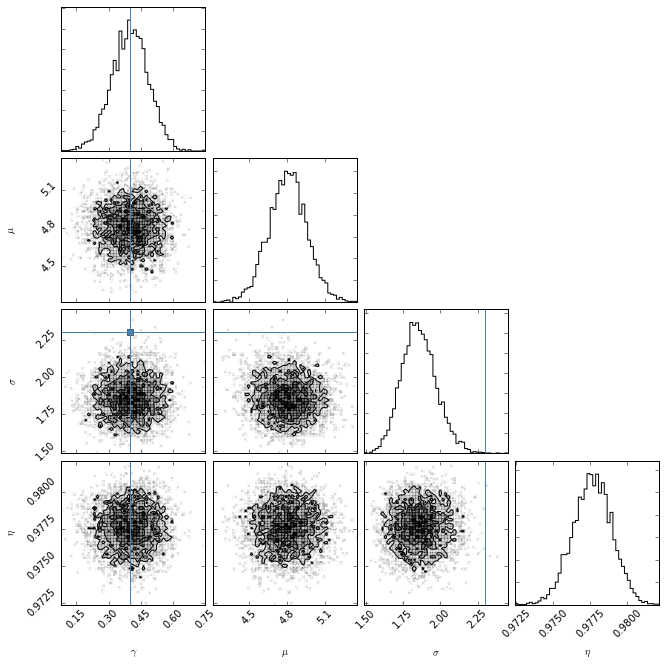

In [158]:
censored_dist_fitter.triangle(truths=[0.4, 5.7, 2.3, 0.7])

#More lessons

 - Just the censoring function (Q in DFM equation) is not enough to capture the fact that I don't have any mass-ratios with $q < 0.05$ or $q > 0.8$. I need to re-normalize the rate equation from
 $$ \Gamma_q(\gamma) = (1-\gamma) q^{-\gamma} $$
 to
 $$ \Gamma_q(\gamma) = \frac{1-\gamma}{0.8^{1-\gamma} - 0.05^{1-\gamma}} q^{-\gamma} $$
 That makes me worry some about what to do in for my actual data, since it does not have such hard limits.
 
 - The integral equation is analytic when I have hard limits that are separable in $q, a$, and $e$. If those things are not true, I need to go through a full 3D integral. I coded the integral up in C so it gets evaluated in ~2 seconds, but that needs to get calculated at every likelihood evaluation. I might be able to pre-calculate a bunch and interpolate, but that is kind of worrying. The good news is that I only really need to run the full calculation once. Testing will be painful though...
 - We get the right answer for mass-ratio in the above test, but not for the other things. $\mu, \sigma$, and $\eta$ should all be almost completely un-constrained, but the fitter does constrain them and *does so incorrectly!*
 

# Next test:

  How does the method act when I have non-sharp cutoffs in mass-ratio? Instead of having a hard cut at q=0.1, let's try a family of logistic functions with equation
  
  $$ Q(q) = \frac{1}{1+e^{-\alpha(q-\beta)}} $$

  where $\alpha$ controls how quickly the completeness rises, and $\beta$ controls where it rises. Here is a plot for intuition:


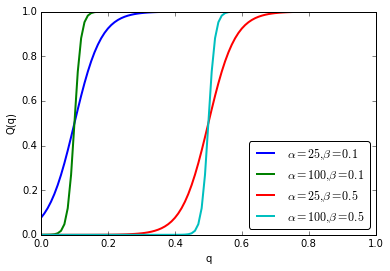

In [7]:
def sigmoid(x, alpha, beta):
    return 1.0 / (1.0 + np.exp(-alpha*(x-beta)))

x = np.arange(0, 1, 0.01)
for beta in [0.1, 0.5]:
    for alpha in [25, 100]:
        y = sigmoid(x, alpha, beta)
        plt.plot(x, y, label=r'$\alpha = {}, \beta = {}$'.format(alpha, beta), lw=2)
plt.xlabel('q')
plt.ylabel('Q(q)')
leg = plt.legend(loc=4, fancybox=True)

What we will do is assign a value of $\alpha$ and $\beta$ to each star in the 'sample.' We will draw values of $(\alpha, \beta)$ from normal distributions:

$$P(\alpha) = N(30, 5) $$
$$P(\beta) = N(0.1, 0.03) $$

Then when we loop through the datasets, we decide if the companion was detected by the following algorithm:

  1. Pick a random number r in [0,1]
  2. Calculate Q(q) using the values of $\alpha$ and $\beta$ for that star, and the true mass-ratio.
  3. If r < Q(q), the companion is detected. Otherwise, it is not.

In [5]:
sample_parameters['alpha'] = np.random.normal(loc=30, scale=5, size=N_sample)
sample_parameters['beta'] = np.random.normal(loc=0.1, scale=0.03, size=N_sample)

In [8]:
# Put all the relevant samples in a numpy array, censoring to "not detect" anything with q < 0.1. 
group_name = 'unconstrained_mn_qprior2'
with h5py.File('Simulation_Data.h5', 'r') as f:
    # Loop through to determine which companions are detected
    maxlen = 0
    detected = np.zeros(len(f[group_name]))
    for ds_name, dataset in f[group_name].iteritems():
        idx = int(ds_name[2:])
        alpha = sample_parameters.ix[idx]['alpha']
        beta = sample_parameters.ix[idx]['beta']
        Q = sigmoid(dataset.attrs['q'], alpha, beta)
        r = np.random.uniform()
        if r < Q:
            # Detected!
            detected[idx] = 1
            if dataset.shape[0] > maxlen:
                maxlen = dataset.shape[0]
    n_datasets = detected.sum()
    
    # Make a big numpy array filled with NaNs of max shape
    censored_data = np.ones((n_datasets, maxlen, 3)) * np.nan
    censored_M_prim = np.ones(n_datasets) * np.nan
    censored_M_sec = np.ones(n_datasets) * np.nan
    censored_Period = np.ones(n_datasets) * np.nan
    censored_a = np.ones(n_datasets) * np.nan
    censored_e = np.ones(n_datasets) * np.nan
    
    # Fill the numpy array where possible
    i = 0
    for ds_name, dataset in f[group_name].iteritems():
        idx = int(ds_name[2:])
        if detected[idx]:
            length = dataset.shape[0]
            df = pd.DataFrame(data=dataset.value, columns=dataset.attrs['df_columns'])
            M1 = dataset.attrs['M_prim']
            df['a'] = 10**(df['Period']*(2./3.)) * (M1*(1+df['q']))**(1./3.)
            df['e'] = 10**(df['e'])
            values = df[['q', 'a', 'e']].sample(n=maxlen) if 'emcee' in group_name.lower() else df[['q', 'a', 'e']]
            #values = values.loc[(values['q'] >= low) & (values['q'] <= high)]
            #length = values.shape[0]
            censored_data[i, :length, :] = values
            censored_M_prim[i] = M1
            censored_M_sec[i] = M1 * dataset.attrs['q']
            censored_Period[i] = dataset.attrs['Period']
            censored_a[i] = dataset.attrs['a']
            censored_e[i] = dataset.attrs['e']
            i += 1

Sample size = 301


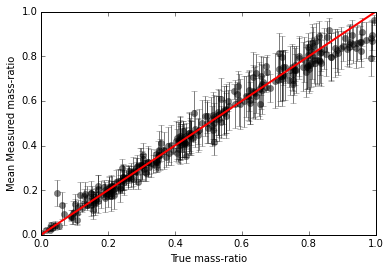

In [9]:
mean_q = np.nanmean(censored_data[:, :, 0], axis=1)
std_q = np.nanstd(censored_data[:, :, 0], axis=1)
true_q = censored_M_sec / censored_M_prim
plt.errorbar(true_q, mean_q, yerr=std_q, alpha=0.5, fmt='ko')
plt.xlabel('True mass-ratio')
plt.ylabel('Mean Measured mass-ratio')
plt.plot([0, 1], [0, 1], 'r-', lw=2)

print('Sample size = {}'.format(censored_data.shape[0]))


## Calculating the integral

Now the integral calculation is more complicated. The eccentricity and semimajor axis integrals are just 1, but the mass-ratio integral is now:
$$
\begin{align}
\int_0^1 Q_{\rm tot}(q)\Gamma(q)dq &= \int_0^1 \frac{1}{N} \sum_{i=1}^N Q_i(q)\Gamma(q)dq \\
 &= \frac{1}{N} \sum_{i=1}^N \int_0^1 \frac{(1-\gamma)q^{-\gamma}}{1+e^{-\alpha_i(q-\beta_i)}}
\end{align}
$$

I will implement the inner integral in C for speed, and then calculate the integral for every value of $\alpha/\beta$ in the sample and sum the results. Here is the relevant C code, listed in 'integration.c' within this repository:

```C
double q_integrand_logisticQ(int n, double args[n])
{
    //unpack arguments
    double q = args[0];
    double gamma = args[1];
    double alpha = args[2];
    double beta = args[3];

    return (1-gamma)*pow(q, -gamma) / (1.0 + exp(-alpha*(q-beta)));
}
```

I compile it into a shared library with

```bash
gcc -shared -o integrandlib.so -fPIC integration.c
```


In [15]:
from scipy.integrate import quad
class CensoredCompleteness(object):
    def __init__(self, alpha_vals, beta_vals):
        """
        A helper function for calculating the completeness function and corresponding integral. 
        The completeness is defined as:
        
        .. math::
            Q(q|\alpha, \beta) = \frac{1}{1+e^{-\alpha (q-\beta)}}
        
        Parameters:
        ============
         - alpha_vals:  An iterable of length N
                        Holds all the values for alpha
                        
         - beta_vals:   An iterable of length N
                        Holds all the values for beta
        """
        self.alpha_vals = np.atleast_1d(alpha_vals)
        self.beta_vals = np.atleast_1d(beta_vals)
        assert len(alpha_vals) == len(beta_vals), 'alpha_vals and beta_vals must be the same length!'
        
        import ctypes
        import os
        lib = ctypes.CDLL('{}/School/Research/BinaryInference/integrandlib.so'.format(os.environ['HOME'])) 
        self.c_integrand = lib.q_integrand_logisticQ # Assign specific function to name c_integrand (for simplicity)
        self.c_integrand.restype = ctypes.c_double
        self.c_integrand.argtypes = (ctypes.c_int, ctypes.c_double)
        self.sigmoid = lambda q, alpha, beta: 1.0 / (1.0 + np.exp(-alpha*(q-beta)))
        
        
    def integral(self, gamma, mu, sigma, eta):
        """ 
        Returns the integral normalization factor in Equation 11
        
        Parameters:
        ===========
         - gamma:    float
                     The mass-ratio power law exponent
         - mu:       float
                     The semimajor-axis log-normal mean
         - sigma:    float
                     The semimajor-axis log-normal width
         - eta:      float
                     The eccentricity power law exponent
                     
        Returns:
        =========
         float - the value of the integral for the input set of parameters
        """
        #return np.mean([quad(self.c_integrand, 0, 1, args=(gamma, alpha, beta))[0] for alpha, beta in zip(self.alpha_vals, self.beta_vals)])
        return np.sum([quad(self.c_integrand, 0, 1, args=(gamma, alpha, beta))[0] for alpha, beta in zip(self.alpha_vals, self.beta_vals)])

    
    def __call__(self, q, a, e):
        """ 
        Gives the average completeness over the whole sample
        
        Parameters:
        ===========
         - q:    float, or numpy.ndarray
                 The mass-ratio
                 
         - a:    float, or numpy.ndarray
                 The semimajor-axis (in AU)
                 
         - e:    float, or numpy.ndarray
                 The eccentricity
                     
        Returns:
        =========
         float, or numpy.ndarray of the same shape as the inputs, containing the completeness
        """
        #return np.nanmean([self.sigmoid(q, alpha, beta) for alpha, beta in zip(self.alpha_vals, self.beta_vals)], axis=0)
        completeness = np.zeros_like(q)
        for alpha, beta in zip(self.alpha_vals, self.beta_vals):
            completeness += self.sigmoid(q, alpha, beta)
        #return completeness / float(len(self.alpha_vals))
        return completeness

In [73]:
# Make the completeness function. The simple thing I have is analytical.
Completeness = CensoredCompleteness(sample_parameters.alpha, sample_parameters.beta)
completeness = Completeness
integral = Completeness.integral
def prior_fcn_simple(q, a, e):
    a_prior = 1.0 / (10*a*np.log(10))
    e_prior = 1.0 / (20*e*np.log(10))
    q_prior = 1.0
    return a_prior * e_prior * q_prior


censored_T_sec = mass2teff(censored_M_sec)
q = censored_data[:, :, 0]

prior_fcn = OrbitPrior(censored_M_prim, censored_T_sec)
empirical_prior = prior_fcn._evaluate_empirical_q_prior(q)

In [74]:
reload(Distributions)
censored_dist_fitter = Distributions.DistributionFitter(censored_data, 
                                                        prior_fcn=prior_fcn_simple, 
                                                        completeness_fcn=completeness,
                                                        integral_fcn=integral,
                                                        q_limits=(0, 1.0))
censored_dist_fitter.prior = empirical_prior
censored_dist_fitter.lnp = np.log(censored_dist_fitter.prior)

Measured value = 0.377


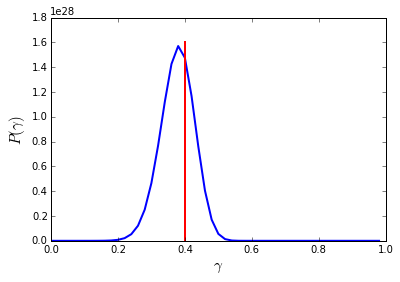

In [75]:
gamma_vals = np.arange(0, 1, 0.02)
ll = np.zeros(gamma_vals.size)
for i, gamma in enumerate(gamma_vals):
    p = [gamma, 5.7, 2.3, 0.7]
    ll[i] = censored_dist_fitter._lnlike_stable(p)

like = np.exp(ll - ll.mean())
centroid = np.sum(like * gamma_vals) / np.sum(like)
print ('Measured value = {:.3f}'.format(centroid))

%matplotlib inline
plt.plot(gamma_vals, like, lw=2)
plt.plot([0.4, 0.4], plt.ylim(), 'r-', lw=2)
plt.xlabel('$\gamma$', fontsize=15)
plt.ylabel('$P(\gamma)$', fontsize=15)

In [76]:
guess_pars = censored_dist_fitter.guess_fit_parameters()
print(guess_pars)

INFO:root:[0.5, 5.0, 5.0, 0.5, -6627.3472163283686]
INFO:root:[0.50000001000000005, 5.0, 5.0, 0.5, -6627.3472156766693]
INFO:root:[0.5, 5.0000000099999999, 5.0, 0.5, -6627.3472163786801]
INFO:root:[0.5, 5.0, 5.0000000099999999, 0.5, -6627.3472160696356]
INFO:root:[0.5, 5.0, 5.0, 0.50000001000000005, -6627.347355704881]
INFO:root:[0.0, 10.0, 0.001, 0.999, inf]
INFO:root:[1e-08, 10.0, 0.001, 0.999, inf]
INFO:root:[0.0, 10.000000010000001, 0.001, 0.999, inf]
INFO:root:[0.0, 10.0, 0.00100001, 0.999, inf]
INFO:root:[0.0, 10.0, 0.001, 0.99900001000000005, inf]
INFO:root:[0.49999993387072955, 5.000000661292705, 4.9999993388395536, 0.50000006599701197, -6627.3481609147293]
INFO:root:[0.49999994387072955, 5.000000661292705, 4.9999993388395536, 0.50000006599701197, -6627.3481602630318]
INFO:root:[0.49999993387072955, 5.000000671292705, 4.9999993388395536, 0.50000006599701197, -6627.3481609650416]
INFO:root:[0.49999993387072955, 5.000000661292705, 4.9999993488395535, 0.50000006599701197, -6627.34

[ 0.38652465  4.8112569   2.16929156  0.999     ]


# Good!
I had been making a mistake earlier. The $\Gamma$'s are *rate densities*, and are calculated as the probability density times the number of stars in the sample. When I do that for both the integral and the completeness function, I get the right answer for q even with variable completeness. Great! On to ...

# Malmquist Bias

My sample is magnitude-limited, meaning that binary stars are actually *more* likely to be in it, and systems with large q are more likely than those with low q. This changes the expected function P(q). I will estimate this with a quick Monte Carlo simulation. the probability of being in my sample is essentially:

\\[
P(obs) =
  \begin{cases}
    1 & \text{if } V < 6 \\
    0 & \text{otherwise}
  \end{cases}
\\]

Now V, the apparent V-band magnitude of the target, is of course a function of the distance ($\rho$) to the star and the absolute magnitude of the star:

$$ V = M_V + 5\log{\rho} - 5 $$

In the case of binary stars, the absolute magnitude is coming from the light of two stars with primary mass $M_1$ and companion mass $qM_1$:

$$ M_{v, total}(q, M_1) = -2.5\log{10^{-M_v(M_1)/2.5} + 10^{-M_v(qM_1)/2.5}} $$

The function $M_v(M)$ is the absolute magnitude of a main-sequence star with mass M, and can be interpolated from stellar evolution models or observational tables such as [this one](http://www.pas.rochester.edu/~emamajek/EEM_dwarf_UBVIJHK_colors_Teff.txt). What we want is the probability that a given binary system has $V<6$, as a function of mass-ratio ($q$). 

We will draw random primary star masses from the Salpeter IMF:

$$P(M)dM \sim M^{-2.35}dM $$
 
Let's normalize it between the primary masses in my sample:

$$ 1 = A\int_{1.5}^{20} m^{-2.35}dm $$
$$ 1 = -\frac{A}{1.35}(20^{-1.35} - 1.5^{-1.35}) $$

which results in $A = 2.407$. Now, I will simulate a sample where stars are uniformly distributed in space within 1 kpc.

          5          4          3           2
-0.06036 x + 0.1632 x - 0.1539 x + 0.09107 x - 0.007406 x + 0.03431
[-0.06036465  0.16323816 -0.15394596  0.09107079 -0.00740625  0.03431462]


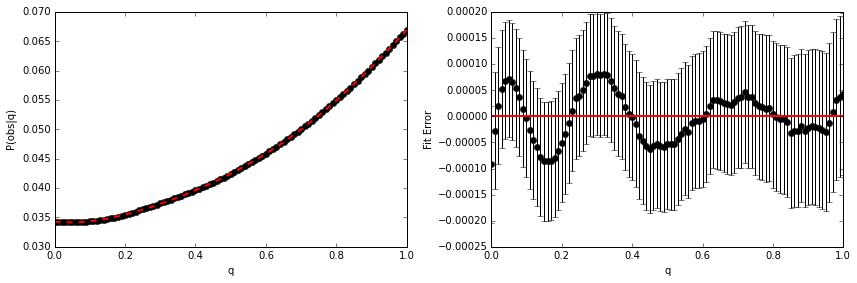

In [4]:
import IMF_utils
from HelperFunctions import add_magnitudes, BinomialErrors
from Mamajek_Table import MamajekTable
# Sample the distance and primary mass distributions, 
# and find the fraction that fall in my V-band limit as a function of q
N_total = 1e7

# Get the mamajek table. Sort by mass, and remove the NaNs
MT = MamajekTable()
df = MT.mam_df.dropna(subset=['Msun']).sort('Msun')
mass = df['Msun']
vmag = df['Mv']

# Interpolate the table with a smoothing spline.
from scipy.interpolate import UnivariateSpline
spline = UnivariateSpline(mass, vmag, s=0.9, ext=3) #The s parameter was fine-tuned. See the MalmquistBias notebook.

def Vmag(q, mass, d):
    """ Get the V-band magnitude as a function of mass-ratio (q), primary mass(mass),
        and distance (d)"""
    M1 = spline(mass)
    M2 = spline(q*mass)
    M_total = add_magnitudes(M1, M2)
    V = M_total + 5*np.log10(d) - 5
    return V    

# Sample the distance such that a sphere around the Earth is uniformly distributed
distance = (np.random.uniform(size=N_total))**(1./3.) * 1000.0

# Sample the IMF
mass = IMF_utils.inverse_imf(np.random.uniform(size=N_total), mmin=1.5, mmax=20.0)

# Get the V_band magnitude
q = np.arange(0.0, 1.01, 0.01)
prob = np.zeros(q.size)
prob_low = np.zeros(q.size)
prob_high = np.zeros(q.size)
for i, qi in enumerate(q):
    V = Vmag(qi, mass, distance)
    prob[i], prob_low[i], prob_high[i] = BinomialErrors(len(V[V<6]), len(V))
    #prob[i] = len(V[V<6]) / len(V)

# Compute the sum
#total = prob.sum()
total = 1.0 
    
# Fit the probability to a polynomial. 
fit = np.poly1d(np.polyfit(q, prob/total, 5))

# Make some plots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
axes[0].errorbar(q, prob/total, yerr=((prob-prob_low)/total, (prob_high-prob)/total), fmt='ko')
axes[0].plot(q, fit(q), 'r--', lw=2)
axes[0].set_xlabel('q')
axes[0].set_ylabel('P(obs|q)')

axes[1].errorbar(q, prob/total-fit(q), yerr=((prob-prob_low)/total, (prob_high-prob)/total), fmt='ko')
axes[1].plot(q, np.zeros_like(q), 'r-', lw=2)
axes[1].set_xlabel('q')
axes[1].set_ylabel('Fit Error')
#axes[1].set_ylim((-0.001, 0.001))
print fit
print fit.coeffs.__repr__()
plt.tight_layout()

As expected, the probability of observing something in a magnitude-limited sample rises with the mass-ratio. The quartic fit has errors of $\sim 0.01 \%$ where $q > 0.1$, and extrapolates smoothly. We can now use that function to modify the form of $\Gamma_q(\gamma)$:

$$ \Gamma(q|obs, \gamma) = \frac{P(obs|q)P(q|\gamma)}{\int P(obs|q)P(q|\gamma)dq} $$

We will need to calculate this value, and worse yet the integral, at every likelihood function evaluation. Here it is for $\gamma = 0.4$:

          5         4          3           2
-0.06411 x + 0.173 x - 0.1629 x + 0.09485 x - 0.007929 x + 0.03395
[-0.06411313  0.17295962 -0.16288746  0.09485366 -0.00792856  0.03394995]


/home/kgullikson/anaconda3/envs/python2/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: RuntimeWarning: divide by zero encountered in power
  app.launch_new_instance()


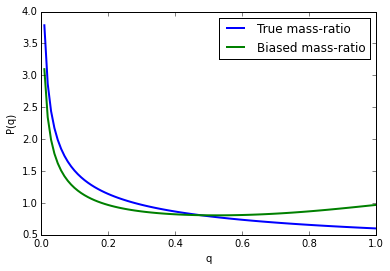

In [218]:
gamma = 0.4
def prior(q, gamma=0.4):
    return (1-gamma)*q**(-gamma)

# Interpolate P(obs|q) (the plot above)
Pobs = fit

# Integrate the bottom (analytically)
#from scipy.integrate import quad
#denominator, _ = quad(lambda x: Pobs(x)*prior(x), 0, 1)
f, e, d, c, b, a = fit.coeffs
denominator = a + (1-gamma)*(b/(2-gamma) + c/(3-gamma) + d/(4-gamma) + e/(5-gamma) + f/(6-gamma))

# Now, calculate P(q|obs) from Baye's theorem.
Pq = Pobs(q)*prior(q, gamma=gamma) / denominator

plt.plot(q, prior(q), lw=2, label='True mass-ratio')
plt.plot(q, Pq, lw=2, label='Biased mass-ratio')
#plt.loglog(q, prior(q), lw=2, label='Prior')
#plt.loglog(q, Pq, lw=2, label='Posterior')
plt.legend(loc='best')
plt.xlabel('q')
plt.ylabel('P(q)')
plt.savefig('Figures/Malmquist.png')
print(fit)

# Go ahead
Adam agrees that I should do this. Let's go!

In [15]:
#Make a simulated sample with malmquist bias
np.random.seed(1)
malm_sample_parameters =ForwardModeling.make_malmquist_sample(true_mrd_alpha, true_sep_mu, 
                                                                   true_sep_sigma, true_ecc_alpha, 
                                                                   size=N_sample, 
                                                                   min_mass=true_min_mass, 
                                                                   max_mass=true_max_mass)
malm_sample_parameters['alpha'] = np.random.normal(loc=30, scale=5, size=N_sample)
malm_sample_parameters['beta'] = np.random.normal(loc=0.1, scale=0.03, size=N_sample)
malm_sample_parameters.head()

index          M0    M_prim          Period             a   big_omega  \
0  246184  135.245338  4.450617  1777022.640806  26102.801379  261.002411   
1  391085   53.011582  4.409782  4393876.043180  47613.927482  124.438088   
2  373830  188.397664  4.963830    52553.665780   2959.595874  230.351334   
3   61229  301.200076  4.506215      344.629487    100.823902  330.303484   
4   24265  322.527259  3.712962     3250.337822    343.515688  105.523256   

          e          i  little_omega         q      Vmag    distance  \
0  0.619618  65.913970    341.015976  0.265176  4.716975  122.777993   
1  0.113750  48.651578     53.970445  0.267608  5.025923  140.305100   
2  0.757524  68.458136    280.437654  0.890471  5.498782  259.888898   
3  0.031753  49.524870    252.015322  0.914562  5.148411  204.003503   
4  0.801387  50.745238    136.758792  0.033137  4.834814  106.144808   

       alpha      beta  
0  22.658237  0.095400  
1  19.485715  0.087880  
2  30.906154  0.161917  
3  21.818416  0.131811  
4  24.413365  0.063806

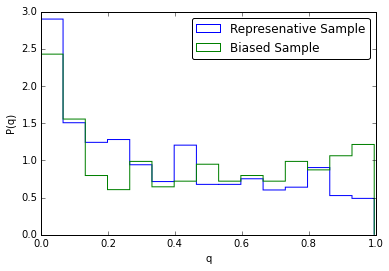

In [7]:
# Compare the malmquist sample to the representative sample to ensure that we get the right MRD
fig, ax = plt.subplots(1, 1)
_, bins, _ = ax.hist(sample_parameters.q.values, bins=15, normed=True, histtype='step', label='Represenative Sample')
ax.hist(malm_sample_parameters.q.values, bins=bins, normed=True, histtype='step', label='Biased Sample')
leg = ax.legend(loc='best', fancybox=True)
ax.set_xlabel('q')
ax.set_ylabel('P(q)')

In [ ]:
# Fit all the orbits in the biased sample
rv1_err = 0.1
rv2_err = 0.2

output_base = 'unconstrained_mn_malmquist'
outfile = h5py.File('Simulation_Data.h5', 'a')
reload(Orbit)
for i, row in malm_sample_parameters.iterrows():
    print '\n\n{}'.format(i)
    # Make some observations of this binary system
    t_rv, rv1, rv2, t_im, rho, theta, K1, K2 = sample_orbit(row, N_rv=2, N_imag=0,
                                                    rv1_err=rv1_err, rv2_err=rv2_err)
        
    # Estimate the mass-ratio prior
    M1_mean = row['M_prim']
    T2_mean = mass2teff(row['M_prim']*row['q'])
    prior = OrbitPrior(M1_mean, T2_mean)
    q_prior = prior._evaluate_empirical_q_prior
    
    # Fit the orbit
    logging.debug('Creating Fitter...')
    fitter = Orbit.SpectroscopicOrbitFitter(rv_times=t_rv, rv1_measurements=rv1, rv1_err=rv1_err, 
                                        rv2_measurements=rv2, rv2_err=rv2_err, 
                                        primary_mass=M1_mean, 
                                        q_prior=q_prior)
    #true_pars = [row['Period'], row['M0'], row['e'], row['little_omega'], row['i'], K1, K1/K2, 0.0]
    logging.debug('Fitting...')
    fitter.fit(backend='multinest', basename='{}/idx{}-'.format(output_base, i), overwrite=False)
    #initial_pars = [[-3, 9], [0, 360], [-20, 0], [0, 360], [-3, 3], [0, 1], [-20, 20]]
    #fitter.fit(backend='emcee', nwalkers=300, n_burn=1000, n_prod=1500, guess=False, initial_pars=initial_pars) 
        
    # Save the MCMC samples and the true parameters
    logging.debug('Saving MCMC samples')
    try:
        ds = outfile.create_dataset('{}/ds{}'.format(output_base, i), data=fitter.samples, maxshape=(None, 8))
    except RuntimeError:
        ds = outfile['{}/ds{}'.format(output_base, i)]
        ds.resize(fitter.samples.shape)
        ds[:] = fitter.samples
    for par in row.keys():
        ds.attrs[par] = row[par]
    ds.attrs['K1'] = K1
    ds.attrs['K2'] = K2
    ds.attrs['df_columns'] = list(fitter.samples.columns)
    ds.attrs['t_rv'] = t_rv
    ds.attrs['rv1'] = rv1
    ds.attrs['rv2'] = rv2
    ds.attrs['rv1_err'] = rv1_err
    ds.attrs['rv2_err'] = rv2_err
    outfile.flush()
    
outfile.close()

In [16]:
# Make the completeness function. The simple thing I have is analytical.
Completeness = CensoredCompleteness(malm_sample_parameters.alpha, malm_sample_parameters.beta)
completeness = Completeness
integral = Completeness.integral
def prior_fcn_simple(q, a, e):
    a_prior = 1.0 / (10*a*np.log(10))
    e_prior = 1.0 / (20*e*np.log(10))
    q_prior = 1.0
    return a_prior * e_prior * q_prior

In [13]:


# Put all the relevant samples in a numpy array, censoring to "not detect" anything with q < 0.1. 
group_name = 'unconstrained_mn_malmquist'
with h5py.File('Simulation_Data.h5', 'r') as f:
    # Loop through to determine which companions are detected
    maxlen = 0
    detected = np.zeros(len(f[group_name]))
    for ds_name, dataset in f[group_name].iteritems():
        idx = int(ds_name[2:])
        alpha = malm_sample_parameters.ix[idx]['alpha']
        beta = malm_sample_parameters.ix[idx]['beta']
        Q = Completeness.sigmoid(dataset.attrs['q'], alpha, beta)
        r = np.random.uniform()
        if r < Q:
            # Detected!
            detected[idx] = 1
            if dataset.shape[0] > maxlen:
                maxlen = dataset.shape[0]
    n_datasets = detected.sum()
    
    # Make a big numpy array filled with NaNs of max shape
    malm_data = np.ones((n_datasets, maxlen, 3)) * np.nan
    malm_M_prim = np.ones(n_datasets) * np.nan
    malm_M_sec = np.ones(n_datasets) * np.nan
    malm_Period = np.ones(n_datasets) * np.nan
    malm_a = np.ones(n_datasets) * np.nan
    malm_e = np.ones(n_datasets) * np.nan
    
    # Fill the numpy array where possible
    i = 0
    for ds_name, dataset in f[group_name].iteritems():
        idx = int(ds_name[2:])
        if detected[idx]:
            length = dataset.shape[0]
            df = pd.DataFrame(data=dataset.value, columns=dataset.attrs['df_columns'])
            M1 = dataset.attrs['M_prim']
            #df['a'] = 10**(df['Period']*(2./3.)) * (M1*(1+df['q']))**(1./3.)
            df['a'] = 10**df['$\log{a}$']
            df['e'] = 10**(df['$\log{e}'])
            values = df[['q', 'a', 'e']].sample(n=maxlen) if 'emcee' in group_name.lower() else df[['q', 'a', 'e']]
            #values = values.loc[(values['q'] >= low) & (values['q'] <= high)]
            #length = values.shape[0]
            malm_data[i, :length, :] = values
            malm_M_prim[i] = M1
            malm_M_sec[i] = M1 * dataset.attrs['q']
            malm_Period[i] = dataset.attrs['Period']
            malm_a[i] = dataset.attrs['a']
            malm_e[i] = dataset.attrs['e']
            i += 1

In [22]:
q = malm_data[:, :, 0]
a = malm_data[:, :, 1]
e = malm_data[:, :, 2]

KS-test p-value = 0.00035


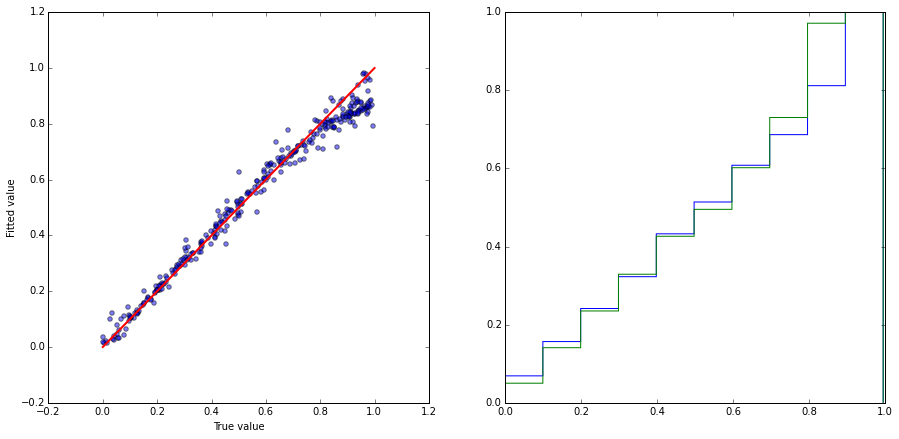

In [42]:
def comparison_plots(true_vals, fitted_vals, low=0, high=1):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
    axes[0].scatter(true_vals, fitted_vals, alpha=0.5)
    axes[0].plot([low, high], [low, high], 'r-', lw=2)
    axes[0].set_xlabel('True value')
    axes[0].set_ylabel('Fitted value')
    
    _, bins, _ = axes[1].hist(true_vals, bins=10, cumulative=True, histtype='step', normed=True)
    axes[1].hist(fitted_vals, bins=bins, cumulative=True, histtype='step', normed=True)
    
    ks_stat, p_value = scipy.stats.ks_2samp(true_vals, fitted_vals)
    print('KS-test p-value = {:.3g}'.format(p_value))
    
comparison_plots(malm_M_sec/malm_M_prim, np.nanmean(q, axis=1))
#plt.scatter(malm_M_sec/malm_M_prim, np.nanmean(q, axis=1))
#plt.plot([0, 1], [0, 1], 'r-', lw=2)

KS-test p-value = 1.16e-06


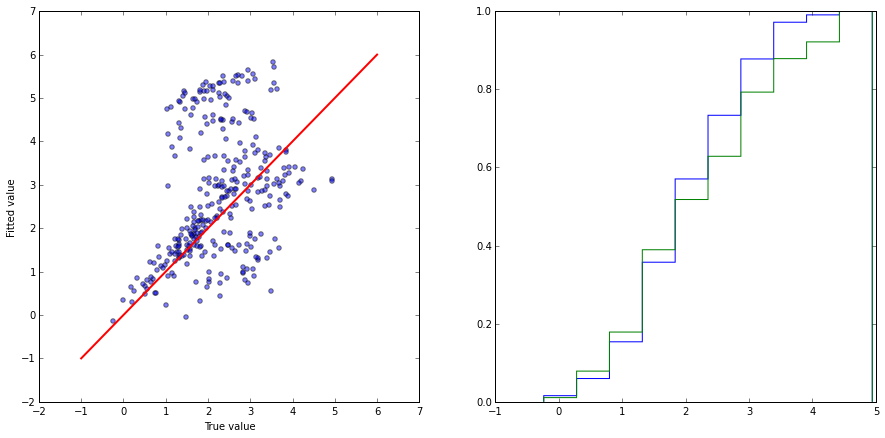

In [45]:
comparison_plots(np.log10(malm_a), np.nanmean(np.log10(a), axis=1), low=-1, high=6)

KS-test p-value = 3.71e-139


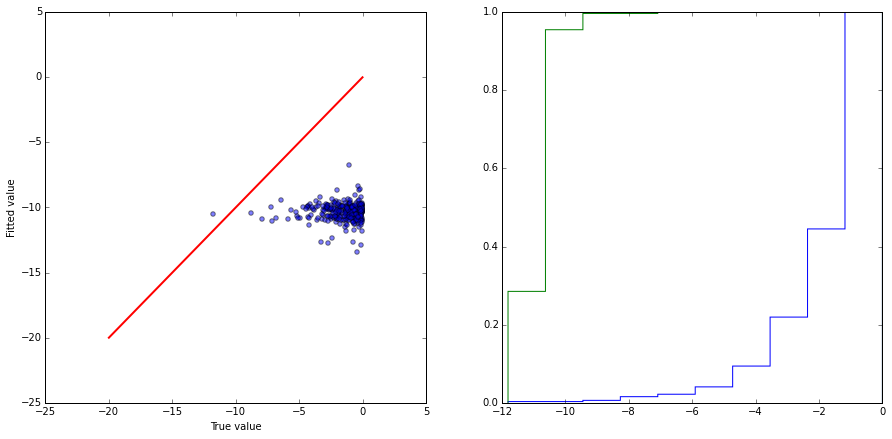

In [46]:
comparison_plots(np.log10(malm_e), np.nanmean(np.log10(e), axis=1), low=-20, high=0)

In [25]:
malm_T_sec = mass2teff(malm_M_sec)

prior_fcn = OrbitPrior(malm_M_prim, malm_T_sec)
empirical_prior = prior_fcn._evaluate_empirical_q_prior(q)

In [36]:
reload(Distributions)
malm_dist_fitter = Distributions.DistributionFitter(malm_data, 
                                                    prior_fcn=prior_fcn_simple, 
                                                    completeness_fcn=completeness,
                                                    integral_fcn=integral,
                                                    malm_pars=fit.coeffs[::-1])
malm_dist_fitter.prior = empirical_prior
malm_dist_fitter.lnp = np.log(malm_dist_fitter.prior)

Measured value = 0.363


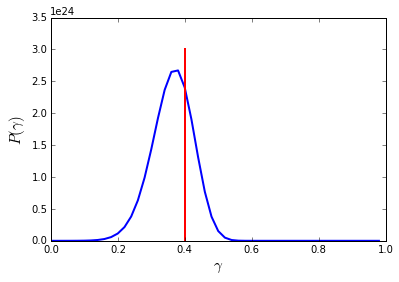

In [47]:
gamma_vals = np.arange(0, 1, 0.02)
ll = np.zeros(gamma_vals.size)
for i, gamma in enumerate(gamma_vals):
    p = [gamma, 5.3, 2.3, 0.7]
    ll[i] = malm_dist_fitter._lnlike_stable(p)

like = np.exp(ll - ll.mean())
centroid = np.sum(like * gamma_vals) / np.sum(like)
print ('Measured value = {:.3f}'.format(centroid))

%matplotlib inline
plt.plot(gamma_vals, like, lw=2)
plt.plot([0.4, 0.4], plt.ylim(), 'r-', lw=2)
plt.xlabel('$\gamma$', fontsize=15)
plt.ylabel('$P(\gamma)$', fontsize=15)

In [47]:
guess_pars = malm_dist_fitter.guess_fit_parameters()

INFO:root:[0.5, 5.0, 5.0, 0.5, -6810.9766109763568]
INFO:root:[0.50000001000000005, 5.0, 5.0, 0.5, -6810.9766103955671]
INFO:root:[0.5, 5.0000000099999999, 5.0, 0.5, -6810.9766110459786]
INFO:root:[0.5, 5.0, 5.0000000099999999, 0.5, -6810.9766107179603]
INFO:root:[0.5, 5.0, 5.0, 0.50000001000000005, -6810.9767431545642]
INFO:root:[0.0, 10.0, 0.001, 0.999, inf]
INFO:root:[1e-08, 10.0, 0.001, 0.999, inf]
INFO:root:[0.0, 10.000000010000001, 0.001, 0.999, inf]
INFO:root:[0.0, 10.0, 0.00100001, 0.999, inf]
INFO:root:[0.0, 10.0, 0.001, 0.99900001000000005, inf]
INFO:root:[0.49999993714159557, 5.0000006285840444, 4.9999993715416728, 0.5000000627326876, -6810.9774644319359]
INFO:root:[0.49999994714159557, 5.0000006285840444, 4.9999993715416728, 0.5000000627326876, -6810.9774638511471]
INFO:root:[0.49999993714159557, 5.0000006385840443, 4.9999993715416728, 0.5000000627326876, -6810.9774645015586]
INFO:root:[0.49999993714159557, 5.0000006285840444, 4.9999993815416728, 0.5000000627326876, -6810.9

In [48]:
par_ranges = [[0, 0.999], [1e-3, 10], [1e-3, 10], [0, 0.999] ]
malm_dist_fitter.fit(backend='emcee', nwalkers=100, n_burn=1, n_prod=400, guess=False, 
                     initial_pars=par_ranges)

/home/kgullikson/anaconda3/envs/python2/lib/python2.7/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/home/kgullikson/anaconda3/envs/python2/lib/python2.7/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))
INFO:root:Done with burn-in iteration 1 / 1


Running burn-in
Running production

INFO:root:Done with production iteration 1 / 400
INFO:root:Done with production iteration 11 / 400
INFO:root:Done with production iteration 21 / 400
INFO:root:Done with production iteration 31 / 400
INFO:root:Done with production iteration 41 / 400
INFO:root:Done with production iteration 51 / 400
INFO:root:Done with production iteration 61 / 400
INFO:root:Done with production iteration 71 / 400
INFO:root:Done with production iteration 81 / 400
INFO:root:Done with production iteration 91 / 400
INFO:root:Done with production iteration 101 / 400
INFO:root:Done with production iteration 111 / 400
INFO:root:Done with production iteration 121 / 400
INFO:root:Done with production iteration 131 / 400
INFO:root:Done with production iteration 141 / 400
INFO:root:Done with production iteration 151 / 400
INFO:root:Done with production iteration 161 / 400
INFO:root:Done with production iteration 171 / 400
INFO:root:Done with production iteration 181 / 400
INFO:root:Done with production iteration 1

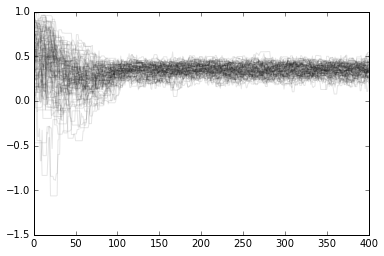

In [49]:
_ = plt.plot(malm_dist_fitter.sampler.chain[:, :, 0].T, 'k-', alpha=0.1)
malm_dist_fitter.make_emcee_samples(200)

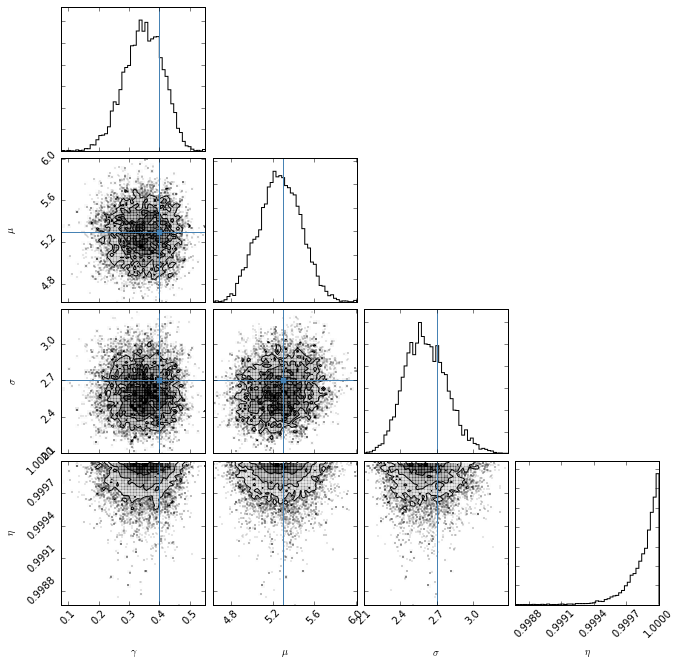

In [50]:
malm_dist_fitter.triangle(truths=[0.4, 5.3, 2.7, 0.7])

#Awesome!
A malmquist-biased sample, with soft detection limits that are different for each star, gets pretty much the right answer for everything except the eccentricity distribution. The eccentricity distribution is still dominated by the prior, **which might be because it is still in terms of probability and not numbers!** *Try adjusting the prior function to account for that change and check if it fixes the eccentricity fit!*

In [265]:
reload(Simulation)
reload(Distributions)
malm_sample_parameters['alpha'] = np.random.normal(loc=30, scale=5, size=N_sample)
malm_sample_parameters['beta'] = np.random.normal(loc=0.2, scale=0.03, size=N_sample)
malm_data, malm_M_prim, malm_M_sec, malm_a, malm_e = Simulation.read_orbit_samples('Simulation_Data.h5', 
                                                                                   'unconstrained_mn_malmquist',
                                                                                   #'unconstrained_mn_qprior2',
                                                                                   censor=True, 
                                                                                   sample_parameters=malm_sample_parameters)
print(malm_data.shape)

(400, 8833, 3)



Mass-ratio comparison: 
KS-test p-value = 8.76e-22

Semi-major axis comparison: 
KS-test p-value = 7.5e-38

Eccentricity comparison: 
KS-test p-value = 3.13e-79


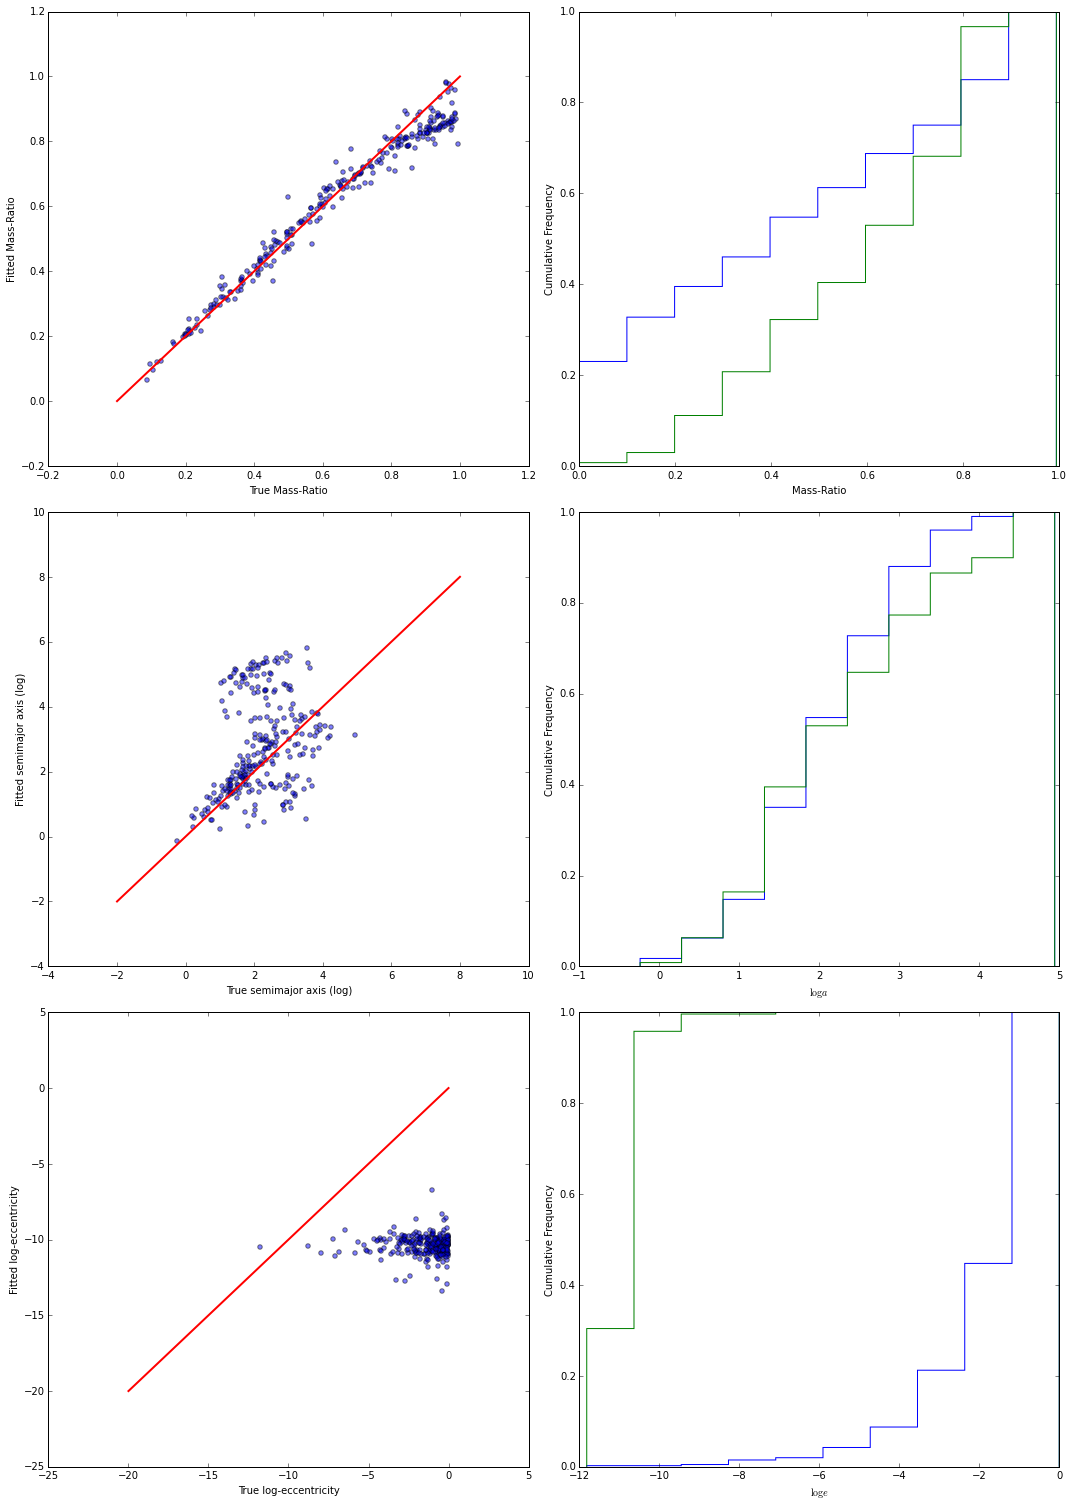

In [266]:
reload(Simulation)
fig, axes = Simulation.comparison_plots(malm_data, malm_M_sec/malm_M_prim, malm_a, malm_e)

In [267]:
reload(Distributions)
malm_T_sec = Distributions.mass2teff(malm_M_sec)
prior = Distributions.OrbitPrior(malm_M_prim, malm_T_sec, gamma=0.0, cache=True)
Completeness = Distributions.CensoredCompleteness(malm_sample_parameters.alpha, malm_sample_parameters.beta)
completeness = Completeness
integral = Completeness.integral
empirical_prior = prior._evaluate_empirical_q_prior(malm_data[:, :, 0])

In [268]:
reload(Distributions)
malm_dist_fitter = Distributions.DistributionFitter(malm_data, 
                                                    prior_fcn=prior,
                                                    #prior_fcn=prior_fcn_simple,
                                                    completeness_fcn=completeness,
                                                    integral_fcn=integral,
                                                    malm_pars=fit.coeffs[::-1])

#malm_dist_fitter.prior = empirical_prior
#malm_dist_fitter.lnp = np.log(empirical_prior)
#malm_dist_fitter.lnp += np.log(prior._cache)

Measured value = 0.366


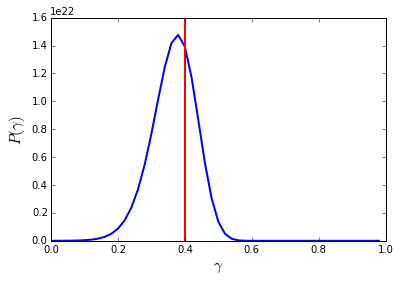

In [269]:
gamma_vals = np.arange(0, 1, 0.02)
ll = np.zeros(gamma_vals.size)
for i, gamma in enumerate(gamma_vals):
    p = [gamma, 5.3, 2.3, 0.7]
    ll[i] = malm_dist_fitter._lnlike(p)

like = np.exp(ll - ll.mean())
centroid = np.sum(like * gamma_vals) / np.sum(like)
print ('Measured value = {:.3f}'.format(centroid))

%matplotlib inline
plt.plot(gamma_vals, like, lw=2)
plt.plot([0.4, 0.4], plt.ylim(), 'r-', lw=2)
plt.xlabel('$\gamma$', fontsize=15)
plt.ylabel('$P(\gamma)$', fontsize=15)

In [271]:
malm_dist_fitter.guess_fit_parameters()

INFO:root:[0.5, 5.0, 5.0, 0.5, -1019.3325738028396]
INFO:root:[0.50000001000000005, 5.0, 5.0, 0.5, -1019.3325733451893]
INFO:root:[0.5, 5.0000000099999999, 5.0, 0.5, -1019.3325738622297]
INFO:root:[0.5, 5.0, 5.0000000099999999, 0.5, -1019.3325735781822]
INFO:root:[0.5, 5.0, 5.0, 0.50000001000000005, -1019.3325781855859]
INFO:root:[0.0, 10.939000402579264, 0.001, 0.999, inf]
INFO:root:[1e-08, 10.939000402579264, 0.001, 0.999, inf]
INFO:root:[0.0, 10.939000412579265, 0.001, 0.999, inf]
INFO:root:[0.0, 10.939000402579264, 0.00100001, 0.999, inf]
INFO:root:[0.0, 10.939000402579264, 0.001, 0.99900001000000005, inf]
INFO:root:[0.49999999639667131, 5.000000042800341, 4.9999999639739201, 0.50000000359612207, -1019.3325766073783]
INFO:root:[0.5000000063966713, 5.000000042800341, 4.9999999639739201, 0.50000000359612207, -1019.3325761497281]
INFO:root:[0.49999999639667131, 5.000000052800341, 4.9999999639739201, 0.50000000359612207, -1019.3325766667683]
INFO:root:[0.49999999639667131, 5.0000000428

array([ 0.37317454,  5.08304991,  2.48941356,  0.93499175])

In [159]:
par_ranges = [[0, 0.999], [1e-3, 10], [1e-3, 10], [0, 0.999] ]
malm_dist_fitter.fit(backend='emcee', nwalkers=100, n_burn=1, n_prod=500, guess=False, 
                     initial_pars=par_ranges)

/home/kgullikson/anaconda3/envs/python2/lib/python2.7/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/home/kgullikson/anaconda3/envs/python2/lib/python2.7/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))
INFO:root:Done with burn-in iteration 1 / 1


Running burn-in
Running production

INFO:root:Done with production iteration 1 / 500
INFO:root:Done with production iteration 11 / 500
INFO:root:Done with production iteration 21 / 500
INFO:root:Done with production iteration 31 / 500
INFO:root:Done with production iteration 41 / 500
INFO:root:Done with production iteration 51 / 500
INFO:root:Done with production iteration 61 / 500
INFO:root:Done with production iteration 71 / 500
INFO:root:Done with production iteration 81 / 500
INFO:root:Done with production iteration 91 / 500
INFO:root:Done with production iteration 101 / 500
INFO:root:Done with production iteration 111 / 500
INFO:root:Done with production iteration 121 / 500
INFO:root:Done with production iteration 131 / 500
INFO:root:Done with production iteration 141 / 500
INFO:root:Done with production iteration 151 / 500
INFO:root:Done with production iteration 161 / 500
INFO:root:Done with production iteration 171 / 500
INFO:root:Done with production iteration 181 / 500
INFO:root:Done with production iteration 1

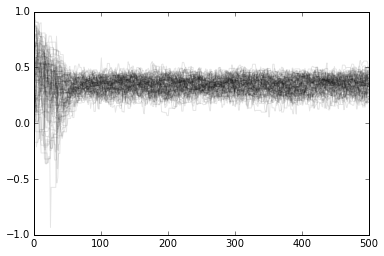

In [160]:
_ = plt.plot(malm_dist_fitter.sampler.chain[:, :, 0].T, 'k-', alpha=0.1)
malm_dist_fitter.make_emcee_samples(200)

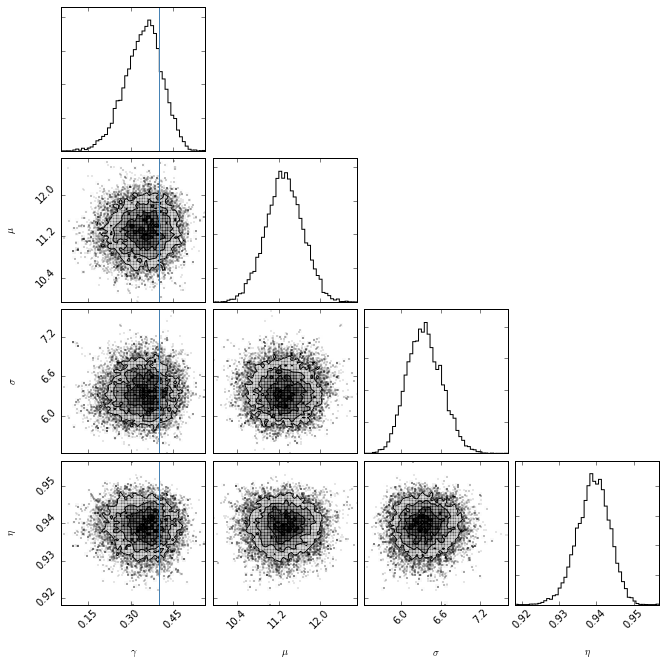

In [161]:
malm_dist_fitter.triangle(truths=[0.4, 5.3, 2.7, 0.7])

In [4]:
malm_dist_fitter.samples.describe()

NameError: name 'malm_dist_fitter' is not defined

In [18]:
reload(Simulation)
par_ranges = [[0, 0.999], [1e-3, 10], [1e-3, 10], [0, 0.999] ]
fitter, prior, Completeness = Simulation.fit_distribution_parameters('Simulation_Data.h5', 'unconstrained_mn_malmquist',
                                                sample_parameters=malm_sample_parameters, censor=True,
                                                backend='emcee', nwalkers=100, n_burn=200, n_prod=300, 
                                                guess=False, initial_pars=par_ranges)

INFO:root:Reading samples
INFO:root:Setting up fitter
INFO:root:Fitting...


In [ ]:
fitter.guess_fit_parameters()

#Possibly the last test:

What about non-detections? So far I have been doing things in such a way that any non-detections are because of detection limits but do actually have a companion. What about the stars that have no companion? For that, I need to add a constant term $f_{\rm bin}$ to the rate densities:

$$\Gamma_{\theta}(\omega) = \Gamma(a, e, q | \gamma, \mu, \sigma, \eta) = f_{\rm bin}\Gamma(q|\gamma) \Gamma(a|\mu, \sigma) \Gamma(e|\eta) $$

